In [1]:
import scipy
import pandas as pd
import numpy as np
from collections import Counter
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

# Normality Check --- Shapiro-wilk Test

In [2]:
def normality_check(dataset):
# shapiro_table = FF.create_table(x_ortho, index=True)

    shapiro_results = scipy.stats.shapiro(dataset)

    sw =[
        ['', 'DF', 'Test Statistic', 'p-value'],
        ['Sample Data', len(dataset) - 1, shapiro_results[0], shapiro_results[1]]
    ]
    normcheck = pd.DataFrame(sw)
    header = normcheck.iloc[0]
    normcheck = normcheck[1:]
    normcheck.rename(columns = header)
    
    if normcheck.iloc[0,3] <= 0.05:
        print('Data is normally distributed')
    else:
        print('Data needs to be transformed')

# MR Chart

In [3]:
def MR_i(dataset):
    MRi = []
    for x in range(len(dataset)-1):
        MRi.append(np.abs(dataset['Overall Duration'].iloc[x]-dataset['Overall Duration'].iloc[x+1]))
        MR = np.mean(MRi)
    return MRi, MR

In [4]:
def control_limits(MR):
    d2 = 1.128
    x_bar = dataset.mean()
    sigma = MR / d2
    LCL = sigma * 0.044319
    UCL = sigma * 3.169822
    Centre = MR
    print('The upper bound is: ' + str(UCL) 
          + '\nThe lower bound is: ' + str(LCL) 
          + '\nThe center line is: ' +str(Centre)
         )
    return UCL, LCL, Centre, sigma

In [5]:
def MRchart(LCL, UCL, Centre):
    plt.axhline(y=LCL, color='b', linestyle='-')
    plt.axhline(y=UCL, color='b', linestyle='-')
    plt.axhline(y=Centre, color = 'r', linestyle = '--')
    plt.plot(x_axis, MRi, marker = '.', color = 'k')
    plt.title(title)
    plt.xlabel('Pick order')
    plt.ylabel('Overall Duration')
    plot = plt.show()
    return plot

In [6]:
def check_outlier(MRi, UCL, LCL):
    outlier = []
    idx = []
    for i in range(len(MRi)):
        if ((MRi[i] > UCL) | (MRi[i] < LCL)):
            outlier.append(MRi[i])
            idx.append(i)            
            
    return outlier, idx

In [7]:
def remove_outlier(outlier, idx):
    for j in idx:
        c1 = np.abs(dataset['Overall Duration'].iloc[j+1] > dataset['Overall Duration'].iloc[j-1])
        c2 = np.abs(dataset['Overall Duration'].iloc[j] > dataset['Overall Duration'].iloc[j+2])
        if c1 <= c2:
            dataset_temp = dataset.drop(dataset.index[j])
        else:
            dataset_temp = dataset.drop(dataset.index[j+1])           
    return dataset_temp

# I chart

In [8]:
def I_control_limits(MR, sigma): 
    d2 = 1.128
    z = 1.96 #95% CI
    x_bar = np.mean(dataset['Overall Duration'].tolist())
    UCL = x_bar + z * sigma
    LCL = x_bar - z * sigma
    Centre = MR
    print('The upper bound is: ' + str(UCL) 
          + '\nThe lower bound is: ' + str(LCL) 
          + '\nThe center line is: ' + str(Centre)
         )
    return UCL, LCL, Centre

In [9]:
def Ichart(LCL, UCL, Centre):
    plt.axhline(y=LCL, color='b', linestyle='-')
    plt.axhline(y=UCL, color='b', linestyle='-')
    plt.axhline(y=Centre, color = 'r', linestyle = '--')
    plt.plot(x_axis, dataset['Overall Duration'].tolist(), marker = '.', color = 'k')
    plt.title(title)
    plt.xlabel('Pick order')
    plt.ylabel('Overall Duration')
    plot = plt.show()

In [10]:
def I_check_outlier(MRi, UCL, LCL):
    outlier = []
    idx = []
    for i in range(len(dataset)):
        if ((dataset['Overall Duration'].tolist()[i] > UCL) | (dataset['Overall Duration'].tolist()[i] < LCL)):
            outlier.append(dataset['Overall Duration'].tolist()[i])
            idx.append(i)                       
    return outlier, idx

In [11]:
def I_remove_outlier(outlier, idx):
    for j in idx:
            dataset_temp = dataset.drop(dataset.index[j])         
    return dataset_temp

# Data Analysis

In [12]:
df = pd.read_csv('Raw Data.csv', index_col = 0)

In [13]:
def duration_to_sec(s):
    if (s != '-' ):
        temp = s.split(':')
        sec = float(temp[0])*60 + float(temp[1])
    else:
        sec = np.nan
    return sec

In [14]:
df = df.drop(['Unnamed: 13'],axis = 1)

In [15]:
df.drop(df.columns[[9,11]], axis = 1,inplace=True)

In [16]:
df = df.reset_index().set_index(['OR case #'])

In [17]:
#list of columns names
columns = df.columns

In [18]:
df = df.rename(columns={'Pick start time (From when staff starts looking at Pick Sheet)': 'Start Time', 
                        'Pick duration for disposable in [mm:ss] (Optional)': 'Disposable Duration',
                        'Pick duration for all in [mm:ss] \n(Stop the stopwatch when staff parks cart)': 
                        'Overall Duration',
                        'Distractions [mm:ss]': 'Distractions'
                       }
              )


In [19]:
df['Disposable Duration'] = df['Disposable Duration'].apply(duration_to_sec)
df['Overall Duration'] = df['Overall Duration'].apply(duration_to_sec)
df['Distractions'] = df['Distractions'].apply(duration_to_sec)

In [20]:
df = df.drop(df[df['Distractions'].notnull()].index)

In [21]:
dataset = df['Overall Duration']
normality_check(dataset)

Data is normally distributed


The upper bound is: 345.6454840425532
The lower bound is: 4.832656914893617
The center line is: 123.0


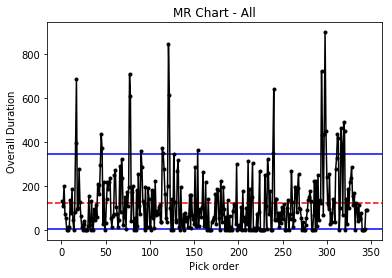

In [22]:
dataset = dataset.reset_index()
title = 'MR Chart - All'
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
sigma = limits[3]
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [23]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The upper bound is: 346.6502674263979
The lower bound is: 4.846705336157843
The center line is: 123.35755813953489


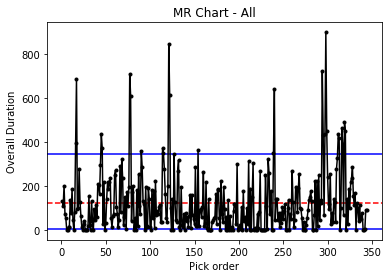

The upper bound is: 347.66090960548354
The lower bound is: 4.860835672414862
The center line is: 123.71720116618076


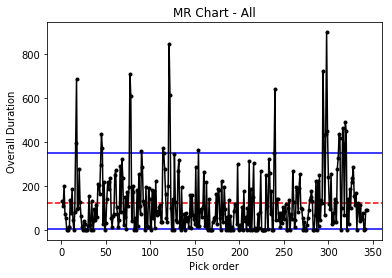

The upper bound is: 348.6774619727511
The lower bound is: 4.875048642217245
The center line is: 124.07894736842105


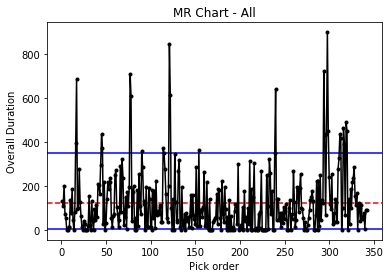

The upper bound is: 349.69997652399076
The lower bound is: 4.889344972546327
The center line is: 124.44281524926686


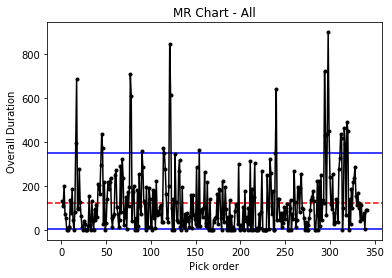

The upper bound is: 350.7285058667084
The lower bound is: 4.90372539893617
The center line is: 124.80882352941177


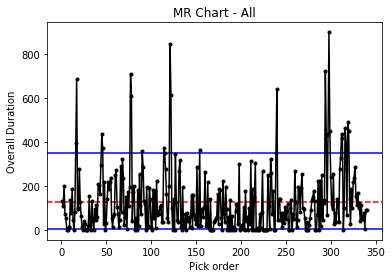

The upper bound is: 344.30259202598387
The lower bound is: 4.813881213519112
The center line is: 122.52212389380531


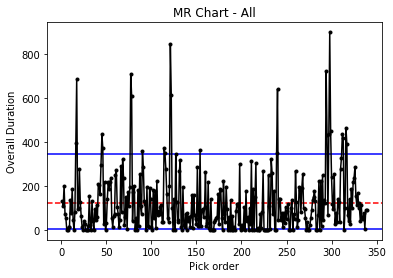

The upper bound is: 338.80307692832264
The lower bound is: 4.736989511204834
The center line is: 120.56508875739645


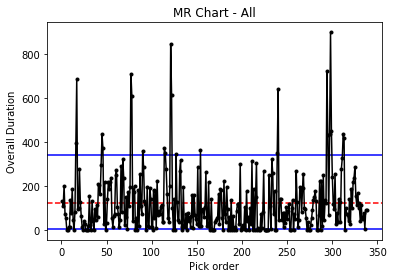

The upper bound is: 339.8084273049646
The lower bound is: 4.7510458599027725
The center line is: 120.92284866468843


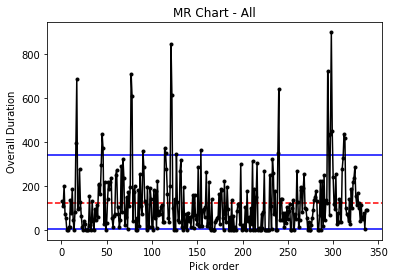

The upper bound is: 333.844628013129
The lower bound is: 4.667662748543567
The center line is: 118.80059523809524


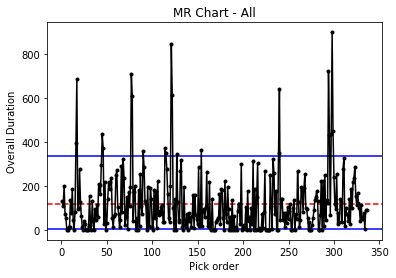

The upper bound is: 327.3251409495078
The lower bound is: 4.576510265163544
The center line is: 116.48059701492538


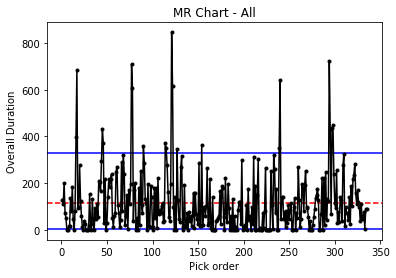

The upper bound is: 324.2498249723957
The lower bound is: 4.533512605108932
The center line is: 115.38622754491018


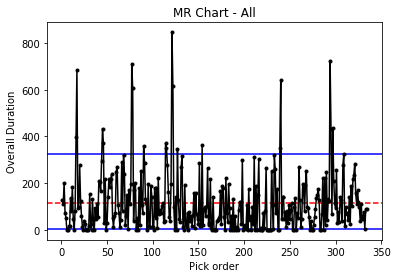

The upper bound is: 320.54844384277897
The lower bound is: 4.481761588716376
The center line is: 114.06906906906907


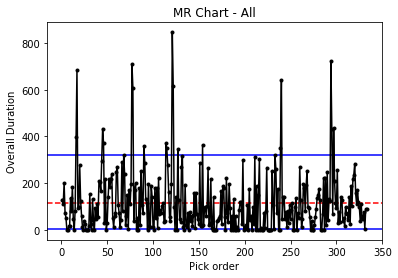

The upper bound is: 320.34588682923186
The lower bound is: 4.478929529287362
The center line is: 113.99698795180723


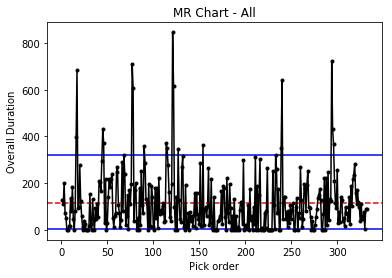

The upper bound is: 321.31369917614796
The lower bound is: 4.492461038439288
The center line is: 114.34138972809667


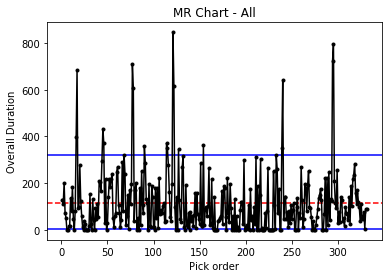

The upper bound is: 309.99094741564585
The lower bound is: 4.334151507092199
The center line is: 110.31212121212121


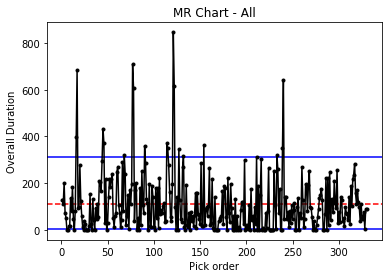

The upper bound is: 310.93316914031345
The lower bound is: 4.347325219879713
The center line is: 110.64741641337386


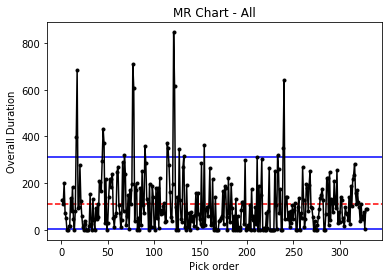

The upper bound is: 311.8811361193998
The lower bound is: 4.360579260184224
The center line is: 110.98475609756098


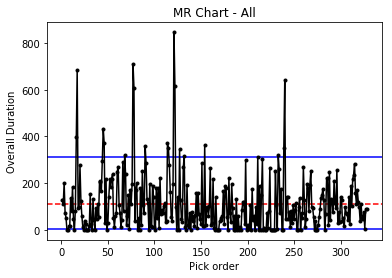

The upper bound is: 312.83490106166096
The lower bound is: 4.37391436495543
The center line is: 111.32415902140673


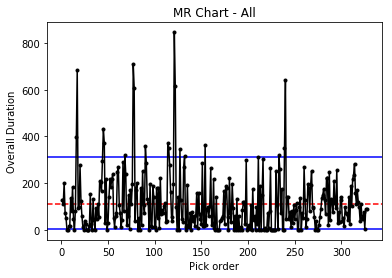

The upper bound is: 313.7945173225863
The lower bound is: 4.387331280185355
The center line is: 111.66564417177914


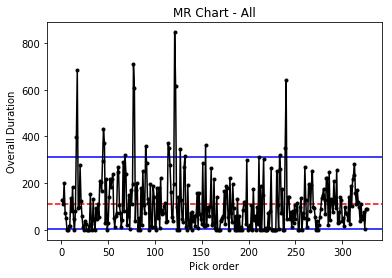

The upper bound is: 314.76003891434806
The lower bound is: 4.400830761047463
The center line is: 112.00923076923077


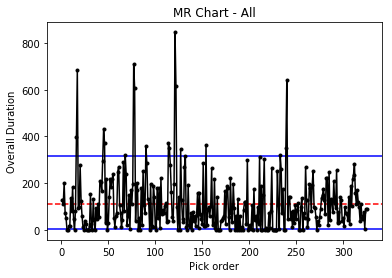

The upper bound is: 315.7315205159356
The lower bound is: 4.414413572038351
The center line is: 112.35493827160494


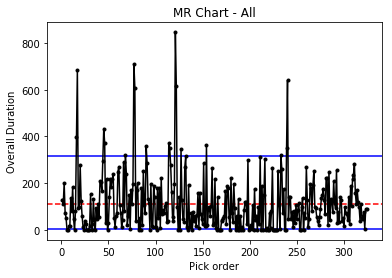

The upper bound is: 316.70901748347717
The lower bound is: 4.4280804871220605
The center line is: 112.70278637770897


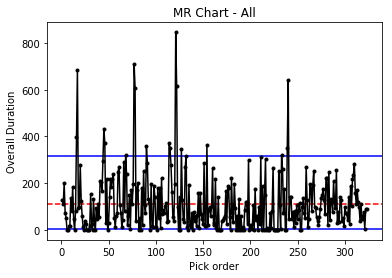

The upper bound is: 317.69258586075506
The lower bound is: 4.441832289877098
The center line is: 113.0527950310559


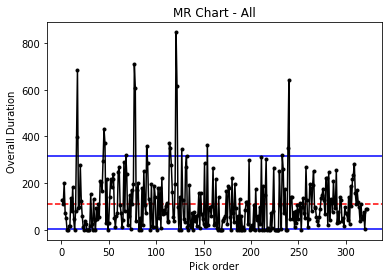

The upper bound is: 318.6822823899163
The lower bound is: 4.455669773646186
The center line is: 113.40498442367601


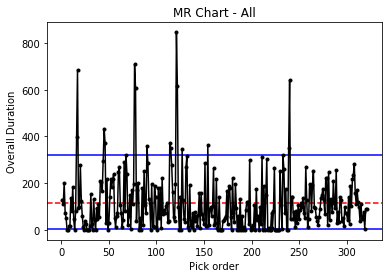

The upper bound is: 313.51345085882093
The lower bound is: 4.383401537566489
The center line is: 111.565625


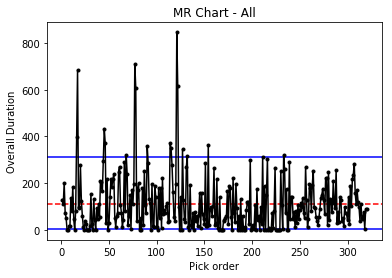

The upper bound is: 314.4962516452122
The lower bound is: 4.397142608217168
The center line is: 111.91536050156739


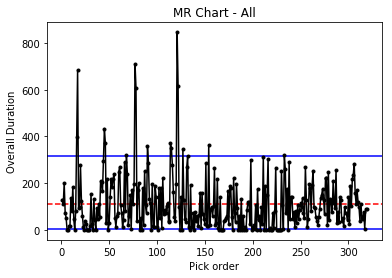

The upper bound is: 315.48523356862484
The lower bound is: 4.410970100695839
The center line is: 112.26729559748428


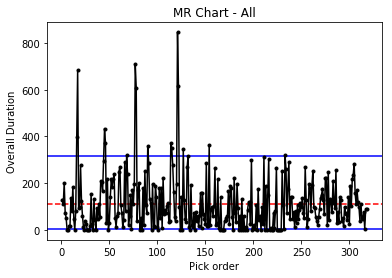

The upper bound is: 311.8885144025326
The lower bound is: 4.360682419961072
The center line is: 110.98738170347004


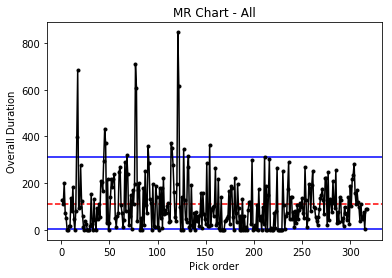

The upper bound is: 312.8221465515307
The lower bound is: 4.373736037234043
The center line is: 111.31962025316456


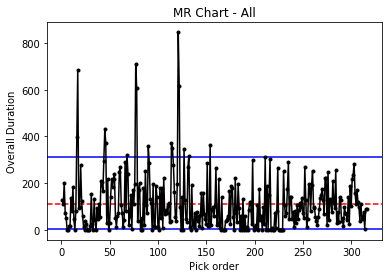

The upper bound is: 313.8152327310593
The lower bound is: 4.3876209135427215
The center line is: 111.67301587301587


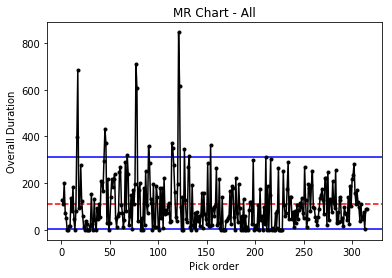

The upper bound is: 314.81464430026654
The lower bound is: 4.401594228554004
The center line is: 112.02866242038216


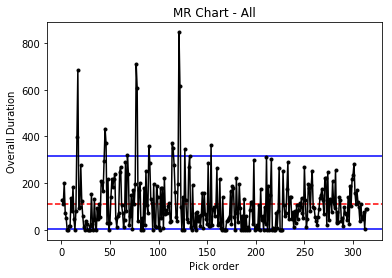

The upper bound is: 315.82044188589043
The lower bound is: 4.415656829923187
The center line is: 112.38658146964856


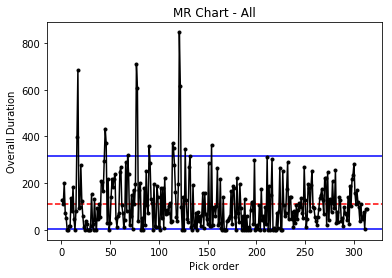

The upper bound is: 316.83268689193494
The lower bound is: 4.429809576172941
The center line is: 112.74679487179488


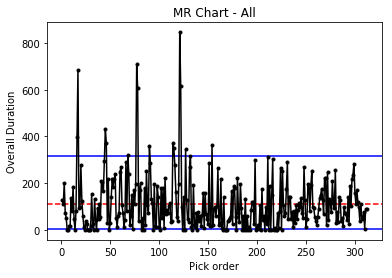

The upper bound is: 317.8514415121662
The lower bound is: 4.444053336868031
The center line is: 113.10932475884245


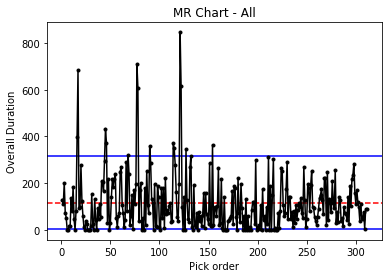

The upper bound is: 318.87676874285063
The lower bound is: 4.458388992793411
The center line is: 113.47419354838709


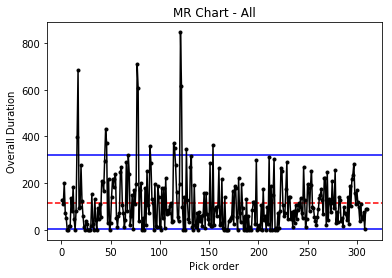

The upper bound is: 319.9087323957401
The lower bound is: 4.472817436135785
The center line is: 113.84142394822007


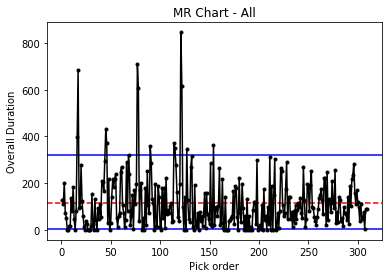

The upper bound is: 320.94739711131075
The lower bound is: 4.487339570668693
The center line is: 114.21103896103897


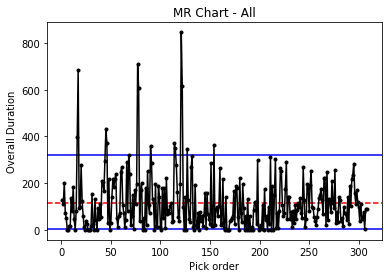

The upper bound is: 321.99282837225957
The lower bound is: 4.50195631194123
The center line is: 114.58306188925081


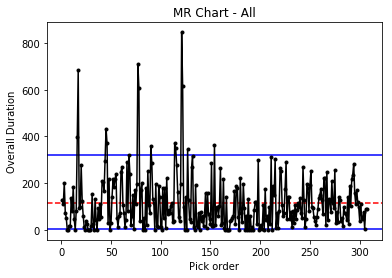

The upper bound is: 323.045092517267
The lower bound is: 4.516668587470449
The center line is: 114.95751633986929


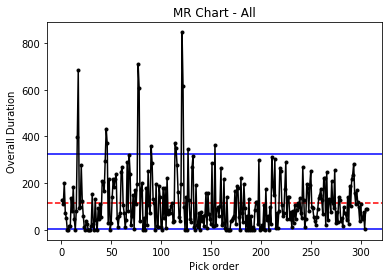

The upper bound is: 324.10425675502853
The lower bound is: 4.531477336937566
The center line is: 115.3344262295082


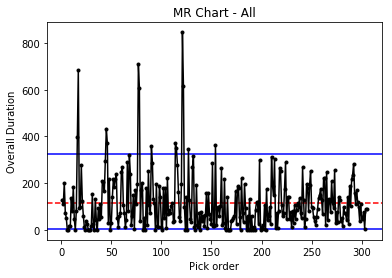

The upper bound is: 325.1703891785648
The lower bound is: 4.546383512388018
The center line is: 115.71381578947368


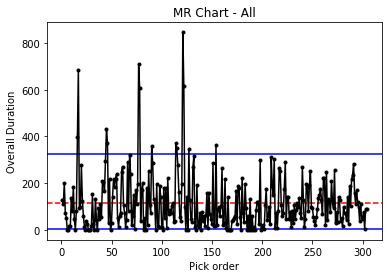

The upper bound is: 326.2435587798142
The lower bound is: 4.561388078435503
The center line is: 116.0957095709571


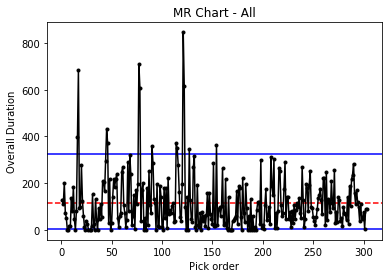

The upper bound is: 327.3238354645155
The lower bound is: 4.576492012470058
The center line is: 116.48013245033113


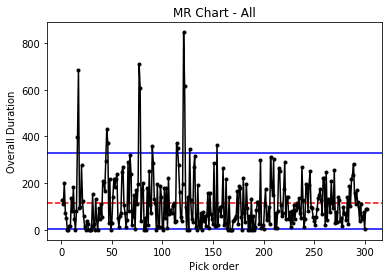

The upper bound is: 328.4112900673877
The lower bound is: 4.591696304870291
The center line is: 116.8671096345515


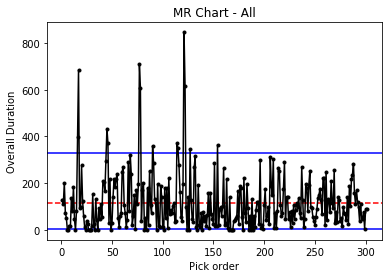

The upper bound is: 329.5059943676123
The lower bound is: 4.6070019592198586
The center line is: 117.25666666666666


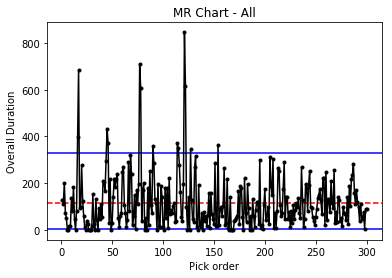

The upper bound is: 330.60802110462777
The lower bound is: 4.622409992528286
The center line is: 117.64882943143813


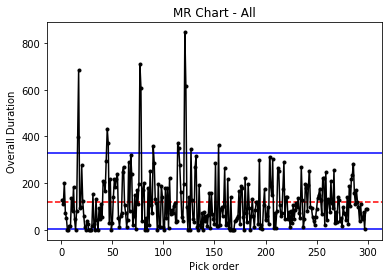

The upper bound is: 331.71744399424057
The lower bound is: 4.637921435456233
The center line is: 118.04362416107382


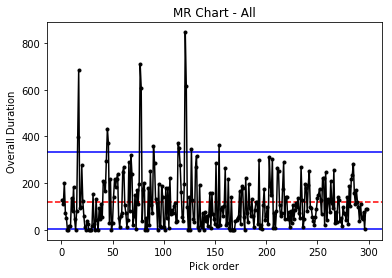

The upper bound is: 332.83433774506295
The lower bound is: 4.653537332545311
The center line is: 118.44107744107744


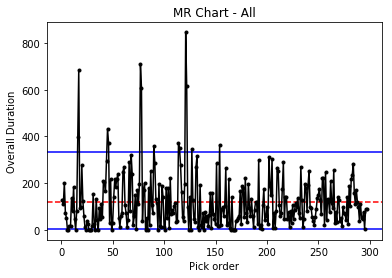

The upper bound is: 333.95877807528274
The lower bound is: 4.669258742452559
The center line is: 118.84121621621621


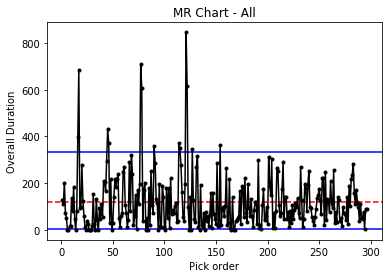

The upper bound is: 335.0908417297752
The lower bound is: 4.685086738189686
The center line is: 119.24406779661017


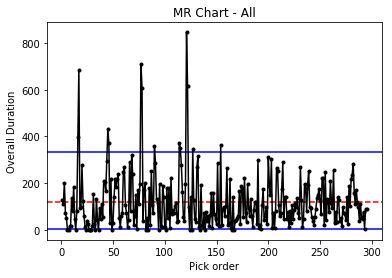

The upper bound is: 336.2306064975636
The lower bound is: 4.701022407367202
The center line is: 119.64965986394557


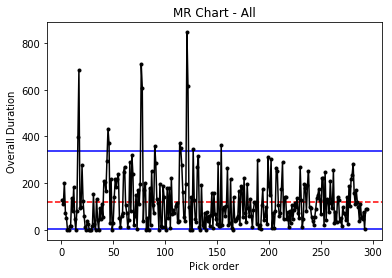

The upper bound is: 337.3781512296372
The lower bound is: 4.717066852443541
The center line is: 120.0580204778157


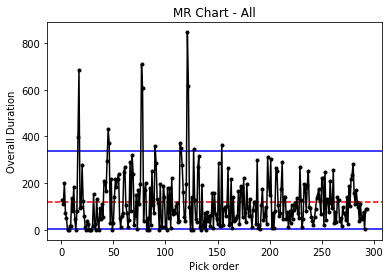

The upper bound is: 338.18710198071506
The lower bound is: 4.728377231492277
The center line is: 120.3458904109589


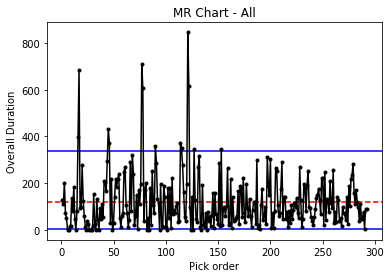

The upper bound is: 339.02092611074556
The lower bound is: 4.740035378738027
The center line is: 120.6426116838488


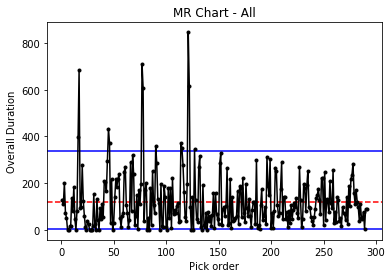

The upper bound is: 340.1899637869895
The lower bound is: 4.7563803283198824
The center line is: 121.05862068965517


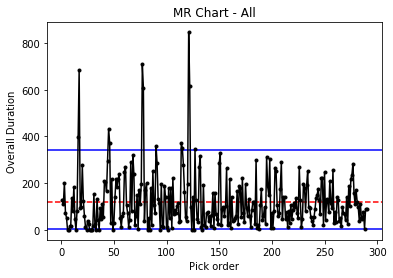

The upper bound is: 341.3670916893666
The lower bound is: 4.772838391739675
The center line is: 121.47750865051903


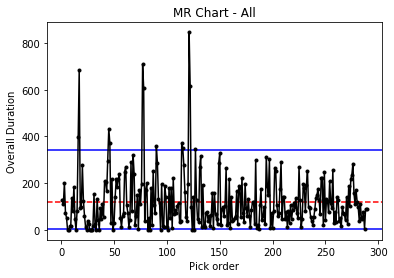

The upper bound is: 342.5523940910658
The lower bound is: 4.789410747266548
The center line is: 121.89930555555556


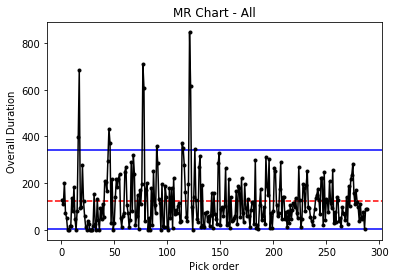

The upper bound is: 340.9652046914771
The lower bound is: 4.767219391726592
The center line is: 121.33449477351917


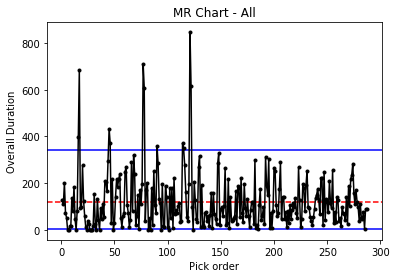

The upper bound is: 342.15739072186676
The lower bound is: 4.783887990998363
The center line is: 121.75874125874125


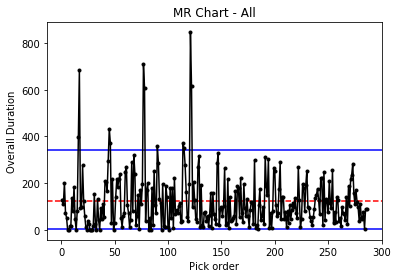

The upper bound is: 331.23003124922235
The lower bound is: 4.631106653602091
The center line is: 117.87017543859649


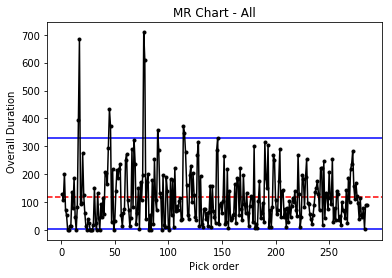

The upper bound is: 325.48975717335935
The lower bound is: 4.550848769478574
The center line is: 115.8274647887324


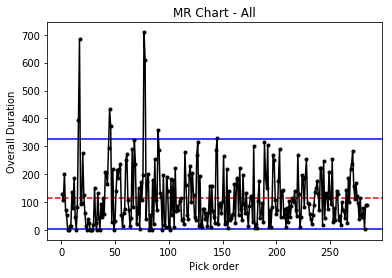

The upper bound is: 320.9799267912187
The lower bound is: 4.487794385760469
The center line is: 114.2226148409894


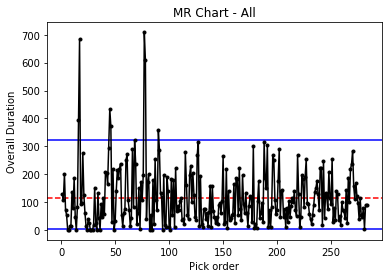

The upper bound is: 322.11815348196774
The lower bound is: 4.503708550248982
The center line is: 114.62765957446808


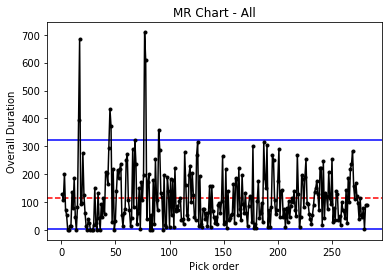

The upper bound is: 323.2644814303021
The lower bound is: 4.519735982812145
The center line is: 115.0355871886121


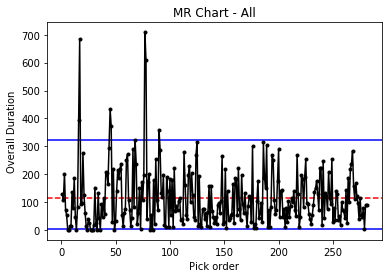

The upper bound is: 322.9537175088652
The lower bound is: 4.51539102393617
The center line is: 114.925


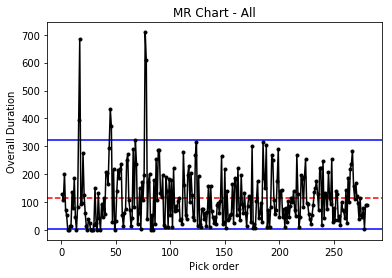

The upper bound is: 324.11125771499024
The lower bound is: 4.531575221154579
The center line is: 115.33691756272401


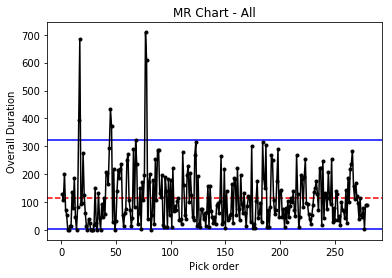

The upper bound is: 325.2771255484974
The lower bound is: 4.547875851446502
The center line is: 115.75179856115108


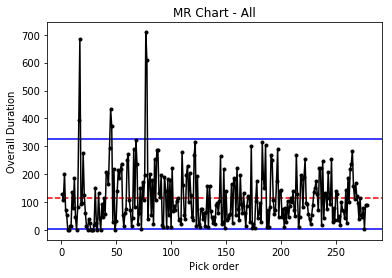

The upper bound is: 314.09497318662466
The lower bound is: 4.391532116522006
The center line is: 111.7725631768953


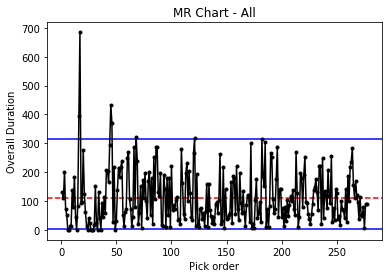

The upper bound is: 309.77565252723815
The lower bound is: 4.3311413525285225
The center line is: 110.23550724637681


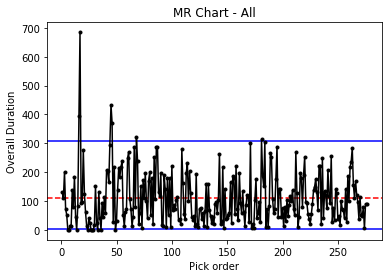

The upper bound is: 307.0599009606706
The lower bound is: 4.293170957446809
The center line is: 109.2690909090909


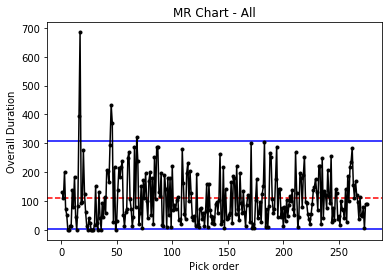

The upper bound is: 308.18055753351973
The lower bound is: 4.3088394645907755
The center line is: 109.66788321167883


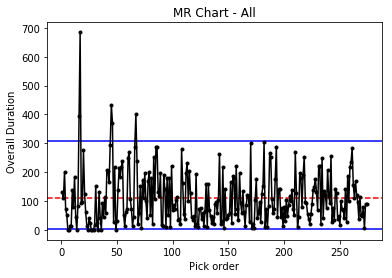

The upper bound is: 303.3597802262749
The lower bound is: 4.241437563323202
The center line is: 107.95238095238095


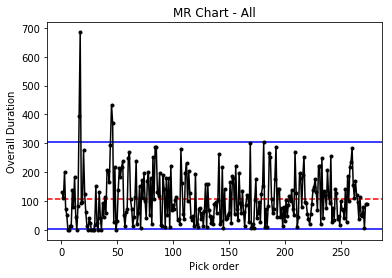

The upper bound is: 301.35500729427406
The lower bound is: 4.213407746010638
The center line is: 107.23897058823529


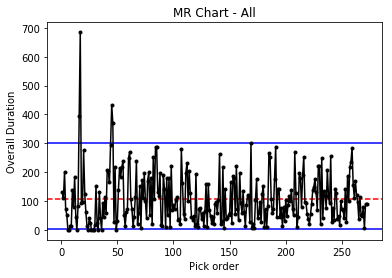

The upper bound is: 302.467018391301
The lower bound is: 4.2289553760697185
The center line is: 107.63468634686348


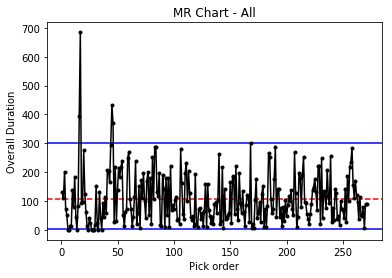

The upper bound is: 295.8646243564487
The lower bound is: 4.136643725374311
The center line is: 105.28518518518518


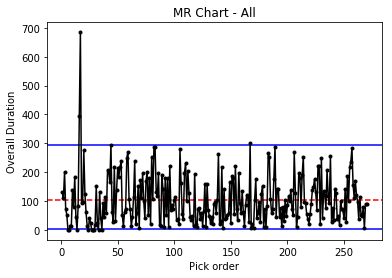

The upper bound is: 296.79734781433734
The lower bound is: 4.1496846377442065
The center line is: 105.61710037174721


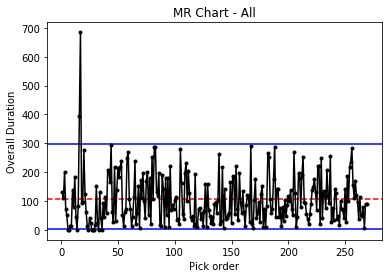

The upper bound is: 297.90480060468934
The lower bound is: 4.165168535646237
The center line is: 106.01119402985074


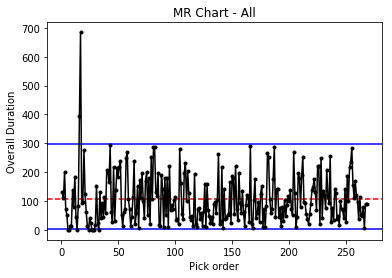

The upper bound is: 299.0205489215609
The lower bound is: 4.1807684178022155
The center line is: 106.40823970037454


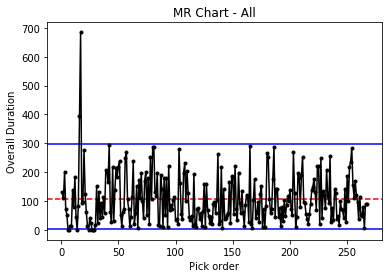

The upper bound is: 300.1446863235216
The lower bound is: 4.1964855923052315
The center line is: 106.80827067669173


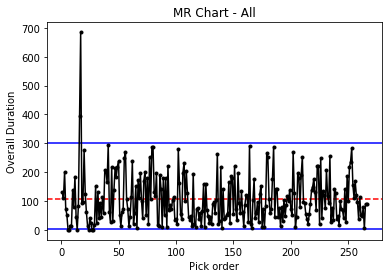

The upper bound is: 301.2773077813462
The lower bound is: 4.2123213869931755
The center line is: 107.21132075471698


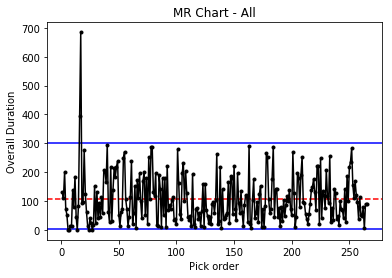

The upper bound is: 302.4185097047604
The lower bound is: 4.228277149822695
The center line is: 107.61742424242425


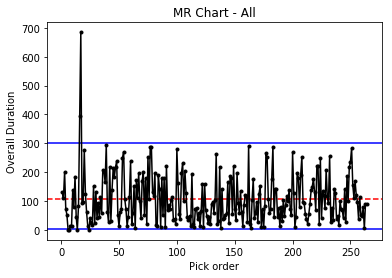

The upper bound is: 303.5683899697975
The lower bound is: 4.244354249251679
The center line is: 108.02661596958175


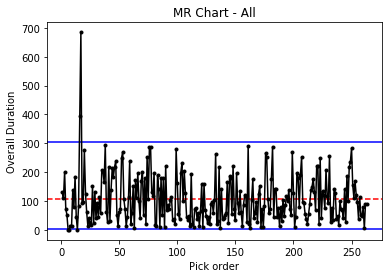

The upper bound is: 296.23231625927133
The lower bound is: 4.141784625223323
The center line is: 105.41603053435115


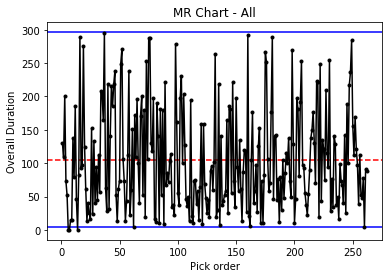

The upper bound is: 297.3673059767398
The lower bound is: 4.157653531833374
The center line is: 105.8199233716475


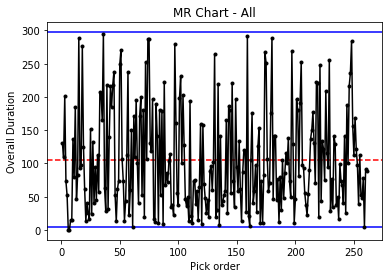

The upper bound is: 298.51102638434264
The lower bound is: 4.17364450695581
The center line is: 106.22692307692307


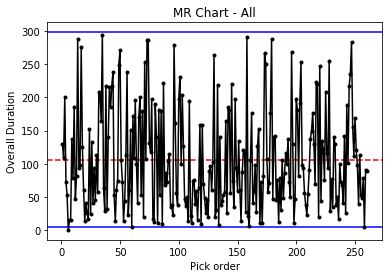

The upper bound is: 299.6635786097648
The lower bound is: 4.189758964511624
The center line is: 106.63706563706563


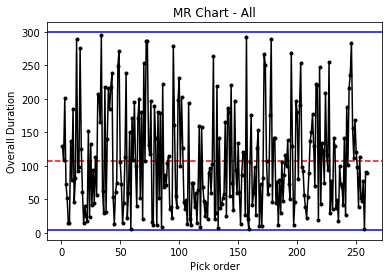

The MR chart went through 86 iterations, no more outliers!


In [24]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - All')

The upper bound is: 478.5464811783961
The lower bound is: 51.09967266775777
The center line is: 106.63706563706563


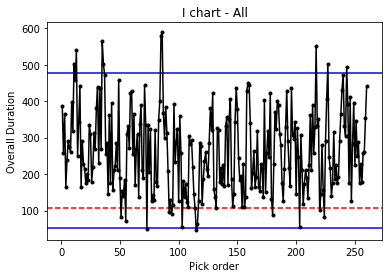

In [25]:
title = 'I chart - All'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [26]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

The upper bound is: 477.6654891974041
The lower bound is: 50.218680686765765
The center line is: 106.26744186046511


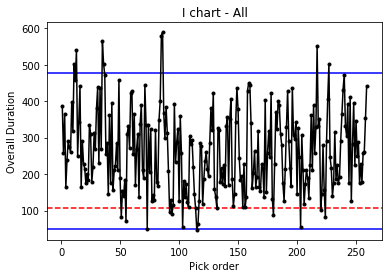

The upper bound is: 476.74666006927265
The lower bound is: 49.299851558634316
The center line is: 105.94941634241245


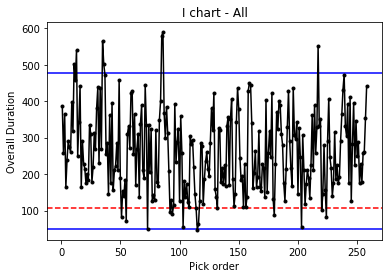

The upper bound is: 475.6222369401441
The lower bound is: 48.17542842950576
The center line is: 104.63671875


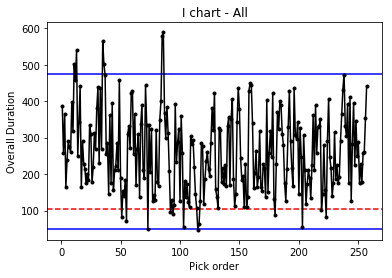

The upper bound is: 476.46168550531917
The lower bound is: 49.01487699468083
The center line is: 104.92941176470588


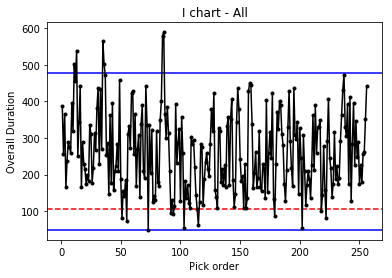

The upper bound is: 475.1822277847309
The lower bound is: 47.73541927409258
The center line is: 105.27165354330708


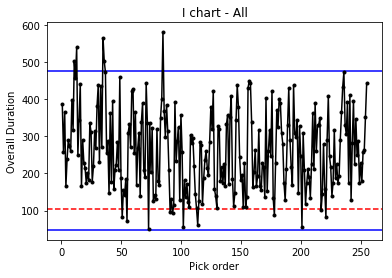

The upper bound is: 473.928128664768
The lower bound is: 46.48132015412966
The center line is: 104.27272727272727


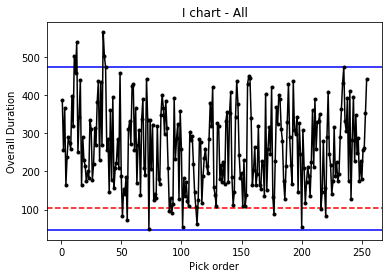

The upper bound is: 472.97241611302667
The lower bound is: 45.525607602388334
The center line is: 104.68650793650794


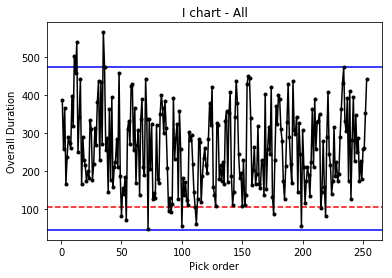

The upper bound is: 472.12419790611284
The lower bound is: 44.677389395474506
The center line is: 104.77689243027888


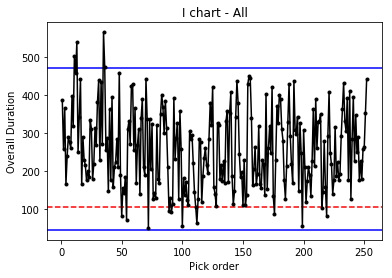

The upper bound is: 471.2692209883869
The lower bound is: 43.82241247774857
The center line is: 105.196


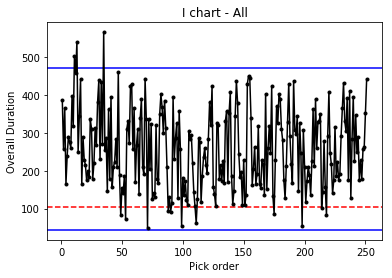

The upper bound is: 470.03940425531914
The lower bound is: 42.59259574468081
The center line is: 103.24899598393574


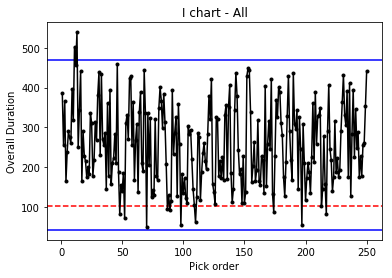

The upper bound is: 468.90412714688546
The lower bound is: 41.457318636247095
The center line is: 103.00403225806451


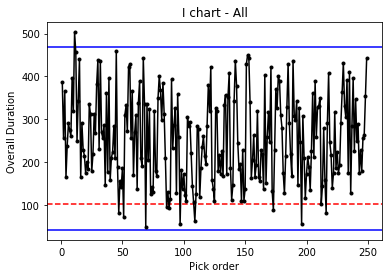

The upper bound is: 467.9048558682224
The lower bound is: 40.458047357584064
The center line is: 103.04858299595142


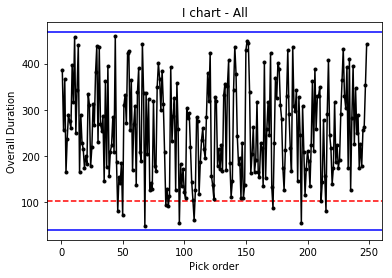

The I chart went through 12 iterations, no more outliers!


In [27]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I chart - All')

# Surgical Specialty -- Ortho

In [28]:
ortho = df[(df['Surgical Specialty'] == 'Ortho')]
ortho = ortho.reset_index().set_index('OR case #')

In [29]:
duplicate_ortho = ortho[ortho.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_ortho

Empty DataFrame
Columns: [Date, Name of Observer, Name of Picker, Picker's Year(s) of Experience, Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest, Surgical Specialty, Start Time, Disposable Duration, Overall Duration, Distractions]
Index: []

In [30]:
#drop duplicates in original dataset
ortho = ortho.drop(duplicate_ortho.index)
ortho.head()

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-7386  2018/6/5           Nathan              B   
GOR-2018-7421  2018/6/5           Nathan              B   
GOR-2018-6930  2018/6/8        Christina        Cecilia   
GOR-2018-7426  2018/6/5           Nathan              B   
GOR-2018-7430  2018/6/5           Nathan              B   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-7386                     > 20 Years   
GOR-2018-7421                     > 20 Years   
GOR-2018-6930                       20 Years   
GOR-2018-7426                     > 20 Years   
GOR-2018-7430                     > 20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-7386                                          Emergency         
GOR-2018-7421                                          Emergency         
GOR-2018-6930                                           Elective         
GOR-2018-7426                                          Emergency         
GOR-2018-7430                                          Emergency         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-7386              Ortho    7:58 AM                  NaN   
GOR-2018-7421              Ortho   11:15 AM                179.0   
GOR-2018-6930              Ortho   12:55 PM                 99.0   
GOR-2018-7426              Ortho   12:42 PM                103.0   
GOR-2018-7430              Ortho    2:04 PM                162.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-7386             387.0           NaN  
GOR-2018-7421             275.0           NaN  
GOR-2018-6930             397.0           NaN  
GOR-2018-7426             318.0           NaN  
GOR-2018-7430             539.0           NaN

In [31]:
#number of duplicates in a given day and start time
ortho_count = duplicate_ortho.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
ortho_count = ortho_count.reset_index().drop(['Disposable Duration'], axis = 1)
ortho_count = ortho_count.rename(columns={'Overall Duration': 'Counts'})
ortho_count

Empty DataFrame
Columns: [Date, Start Time, Counts]
Index: []

In [32]:
duplicate_ortho = duplicate_ortho.drop_duplicates(keep = 'first')
duplicate_ortho

Empty DataFrame
Columns: [Date, Name of Observer, Name of Picker, Picker's Year(s) of Experience, Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest, Surgical Specialty, Start Time, Disposable Duration, Overall Duration, Distractions]
Index: []

In [33]:
for i in range(len(ortho_count['Counts'])):
    for j in range(len(duplicate_ortho['Overall Duration'])):
        if ortho_count['Date'][i] == duplicate_ortho['Date'][j] and ortho_count['Start Time'][i] == duplicate_ortho['Start Time'][j]:
            duplicate_ortho['Disposable Duration'][j] /= ortho_count['Counts'][i]
            duplicate_ortho['Overall Duration'][j] /= ortho_count['Counts'][i]

In [34]:
duplicate_ortho

Empty DataFrame
Columns: [Date, Name of Observer, Name of Picker, Picker's Year(s) of Experience, Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest, Surgical Specialty, Start Time, Disposable Duration, Overall Duration, Distractions]
Index: []

In [35]:
ortho = pd.concat([ortho, duplicate_ortho],axis = 0)

In [36]:
ortho.tail()

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-8688  2018/7/6           Nathan           Ella   
GOR-2018-8689  2018/7/6           Nathan           Ella   
GOR-2018-6387  2018/7/6           Nathan           Ella   
GOR-2018-8674  2018/7/6           Nathan           Ella   
GOR-2018-8601  2018/7/6           Nathan           Ella   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-8688                     > 20 Years   
GOR-2018-8689                     > 20 Years   
GOR-2018-6387                     > 20 Years   
GOR-2018-8674                     > 20 Years   
GOR-2018-8601                     > 20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-8688                                          Emergency         
GOR-2018-8689                                          Emergency         
GOR-2018-6387                                           Elective         
GOR-2018-8674                                           Elective         
GOR-2018-8601                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-8688              Ortho    7:11 AM                171.0   
GOR-2018-8689              Ortho    7:18 AM                 88.0   
GOR-2018-6387              Ortho   10:47 AM                119.0   
GOR-2018-8674              Ortho   10:53 AM                 72.0   
GOR-2018-8601              Ortho   11:40 AM                139.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-8688             347.0           NaN  
GOR-2018-8689             249.0           NaN  
GOR-2018-6387             288.0           NaN  
GOR-2018-8674             175.0           NaN  
GOR-2018-8601             442.0           NaN

# ORTHO

## MR Chart

In [37]:
dataset = ortho['Overall Duration']
normality_check(dataset)

Data is normally distributed


The upper bound is: 391.4438452169875
The lower bound is: 5.472988633485309
The center line is: 139.29761904761904


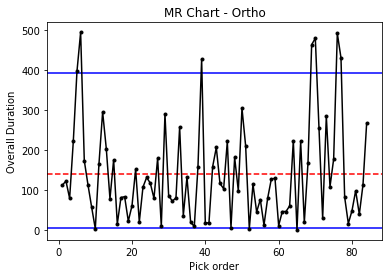

In [38]:
title = 'MR Chart - Ortho'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [39]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The upper bound is: 367.0430691062121
The lower bound is: 5.131828153037683
The center line is: 130.6144578313253


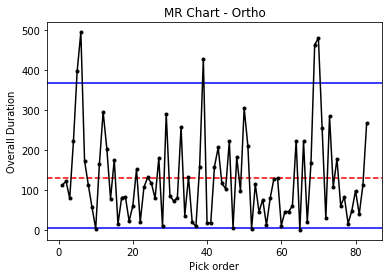

The upper bound is: 339.78534347431247
The lower bound is: 4.750723112350805
The center line is: 120.91463414634147


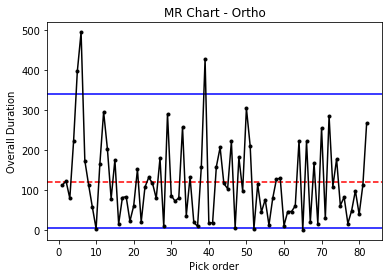

The upper bound is: 343.9802242579459
The lower bound is: 4.809374014972419
The center line is: 122.4074074074074


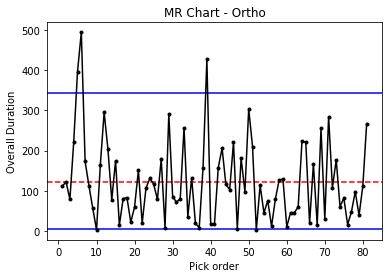

The upper bound is: 348.27997706117026
The lower bound is: 4.869491190159575
The center line is: 123.9375


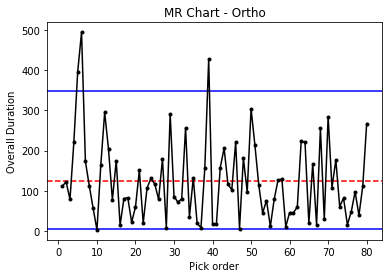

The upper bound is: 352.68858436574203
The lower bound is: 4.931130319148937
The center line is: 125.50632911392405


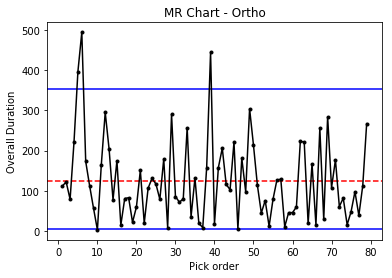

The upper bound is: 357.21023288325154
The lower bound is: 4.994349938625205
The center line is: 127.11538461538461


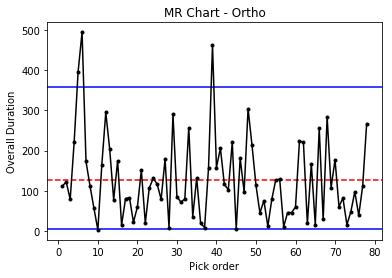

The upper bound is: 350.31686213963343
The lower bound is: 4.897969984802431
The center line is: 124.66233766233766


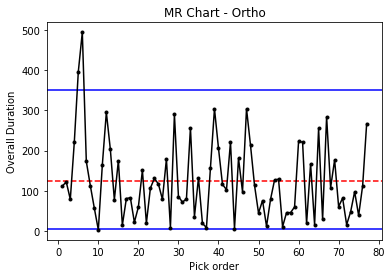

The upper bound is: 354.70444249253455
The lower bound is: 4.959315124580067
The center line is: 126.22368421052632


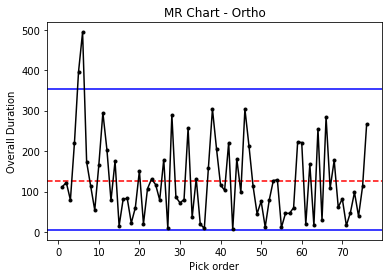

The upper bound is: 329.75890569739954
The lower bound is: 4.61053804964539
The center line is: 117.34666666666666


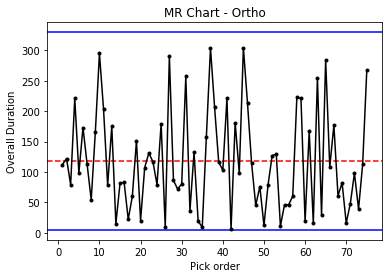

The MR chart went through 9 iterations, no more outliers!


In [40]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR chart - Ortho')

## I Chart

The upper bound is: 573.486562150056
The lower bound is: 146.03975363941765
The center line is: 117.34666666666666


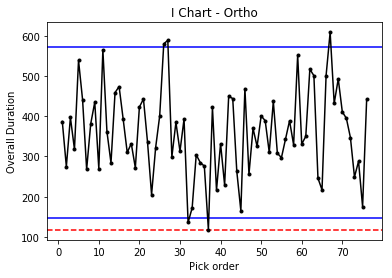

In [41]:
title = 'I Chart - Ortho'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [42]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

The upper bound is: 570.1634042553192
The lower bound is: 142.71659574468083
The center line is: 116.01351351351352


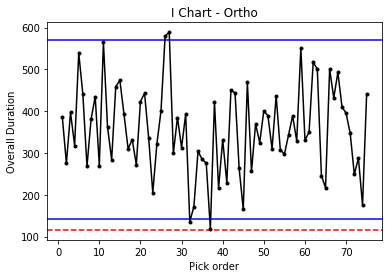

The upper bound is: 573.3855664174814
The lower bound is: 145.93875790684302
The center line is: 113.27397260273973


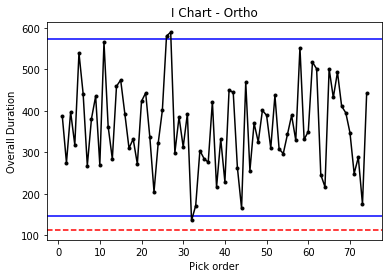

The upper bound is: 576.4494316525795
The lower bound is: 149.00262314194111
The center line is: 113.84722222222223


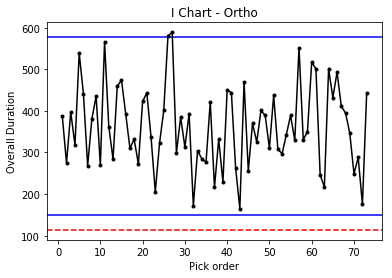

The upper bound is: 573.3067375886525
The lower bound is: 145.85992907801415
The center line is: 115.19718309859155


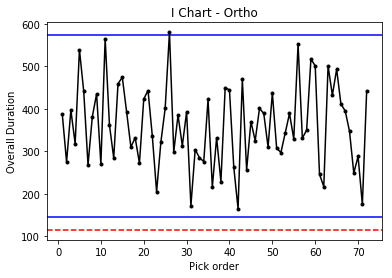

The upper bound is: 570.2022774947558
The lower bound is: 142.75546898411744
The center line is: 111.72857142857143


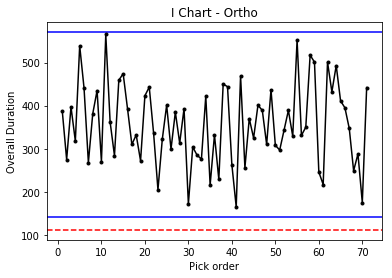

The I chart went through 5 iterations, no more outliers!


In [43]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I chart - Ortho')

In [44]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

OR case #  Overall Duration
0  GOR-2018-7386             387.0
1  GOR-2018-7421             275.0
2  GOR-2018-6930             397.0
3  GOR-2018-7426             318.0
4  GOR-2018-7430             539.0

# Surgical Specialty -- General Surgery# 

In [45]:
GS = df[(df['Surgical Specialty'] == 'General Surgery')]
GS.head()

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-6929  2018/6/8        Christina        Cecilia   
GOR-2018-7414  2018/6/5           Jialin              B   
GOR-2018-7082  2018/6/8        Christina        Cecilia   
GOR-2018-7420  2018/6/5           Nathan              B   
GOR-2018-7453  2018/6/6             Haya              C   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6929                       20 Years   
GOR-2018-7414                     > 20 Years   
GOR-2018-7082                       20 Years   
GOR-2018-7420                     > 20 Years   
GOR-2018-7453                       20 years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6929                                           Elective         
GOR-2018-7414                                          Emergency         
GOR-2018-7082                                           Elective         
GOR-2018-7420                                          Emergency         
GOR-2018-7453                                          Emergency         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6929    General Surgery   10:41 AM                257.0   
GOR-2018-7414    General Surgery   10:32 AM                 88.0   
GOR-2018-7082    General Surgery   11:00 AM                132.0   
GOR-2018-7420    General Surgery   11:24 AM                216.0   
GOR-2018-7453    General Surgery   10:49 AM                133.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6929             257.0           NaN  
GOR-2018-7414             165.0           NaN  
GOR-2018-7082             238.0           NaN  
GOR-2018-7420             260.0           NaN  
GOR-2018-7453             165.0           NaN

In [46]:
duplicate_GS = GS[GS.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_GS

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-8626  2018/7/5             Emma         Elaine   
GOR-2018-8628  2018/7/5             Emma         Elaine   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-8626                     > 20 Years   
GOR-2018-8628                     > 20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-8626                                          Emergency         
GOR-2018-8628                                          Emergency         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-8626    General Surgery    8:28 AM                305.0   
GOR-2018-8628    General Surgery    8:28 AM                305.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-8626             473.0           NaN  
GOR-2018-8628             473.0           NaN

In [47]:
#drop duplicates in original dataset
GS = GS.drop(duplicate_GS.index)
GS.head()

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-6929  2018/6/8        Christina        Cecilia   
GOR-2018-7414  2018/6/5           Jialin              B   
GOR-2018-7082  2018/6/8        Christina        Cecilia   
GOR-2018-7420  2018/6/5           Nathan              B   
GOR-2018-7453  2018/6/6             Haya              C   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6929                       20 Years   
GOR-2018-7414                     > 20 Years   
GOR-2018-7082                       20 Years   
GOR-2018-7420                     > 20 Years   
GOR-2018-7453                       20 years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6929                                           Elective         
GOR-2018-7414                                          Emergency         
GOR-2018-7082                                           Elective         
GOR-2018-7420                                          Emergency         
GOR-2018-7453                                          Emergency         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6929    General Surgery   10:41 AM                257.0   
GOR-2018-7414    General Surgery   10:32 AM                 88.0   
GOR-2018-7082    General Surgery   11:00 AM                132.0   
GOR-2018-7420    General Surgery   11:24 AM                216.0   
GOR-2018-7453    General Surgery   10:49 AM                133.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6929             257.0           NaN  
GOR-2018-7414             165.0           NaN  
GOR-2018-7082             238.0           NaN  
GOR-2018-7420             260.0           NaN  
GOR-2018-7453             165.0           NaN

In [48]:
#number of duplicates in a given day and start time
GS_count = duplicate_GS.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
GS_count = GS_count.reset_index().drop(['Disposable Duration'], axis = 1)
GS_count = GS_count.rename(columns={'Overall Duration': 'Counts'})
GS_count

Date Start Time  Counts
0  2018/7/5    8:28 AM       2

In [49]:
duplicate_GS = duplicate_GS.drop_duplicates(keep = 'first')
duplicate_GS

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-8626  2018/7/5             Emma         Elaine   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-8626                     > 20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-8626                                          Emergency         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-8626    General Surgery    8:28 AM                305.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-8626             473.0           NaN

In [50]:
for i in range(len(GS_count['Counts'])):
    for j in range(len(duplicate_GS['Overall Duration'])):
        if GS_count['Date'][i] == duplicate_GS['Date'][j] and GS_count['Start Time'][i] == duplicate_GS['Start Time'][j]:
            duplicate_GS['Disposable Duration'][j] /= GS_count['Counts'][i]
            duplicate_GS['Overall Duration'][j] /= GS_count['Counts'][i]

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [51]:
duplicate_GS

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-8626  2018/7/5             Emma         Elaine   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-8626                     > 20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-8626                                          Emergency         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-8626    General Surgery    8:28 AM                152.5   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-8626             236.5           NaN

In [52]:
GS = pd.concat([GS, duplicate_GS],axis = 0)

In [53]:
GS.tail(1)

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-8626  2018/7/5             Emma         Elaine   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-8626                     > 20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-8626                                          Emergency         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-8626    General Surgery    8:28 AM                152.5   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-8626             236.5           NaN

In [54]:
dataset = GS['Overall Duration']
normality_check(dataset)

Data is normally distributed


The upper bound is: 267.881940908899
The lower bound is: 3.7454026564083085
The center line is: 95.32738095238095


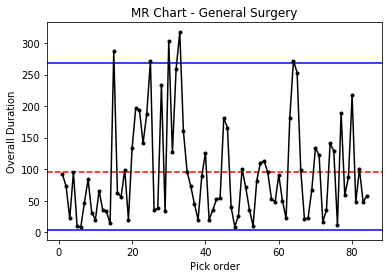

In [55]:
title = 'MR Chart - General Surgery'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [56]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The upper bound is: 258.8532224750064
The lower bound is: 3.6191672487823636
The center line is: 92.1144578313253


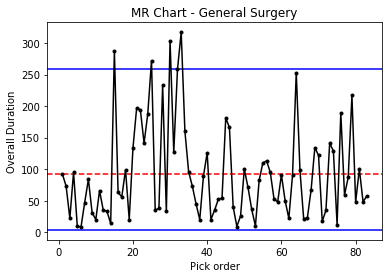

The upper bound is: 244.32673790217956
The lower bound is: 3.416064591982356
The center line is: 86.9451219512195


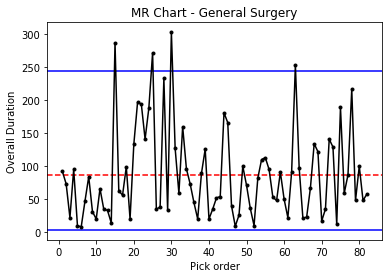

The upper bound is: 240.5433065953069
The lower bound is: 3.363166387575519
The center line is: 85.59876543209876


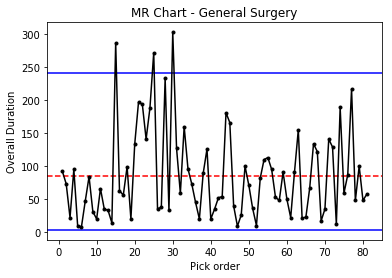

The upper bound is: 241.23174407136526
The lower bound is: 3.37279180518617
The center line is: 85.84375


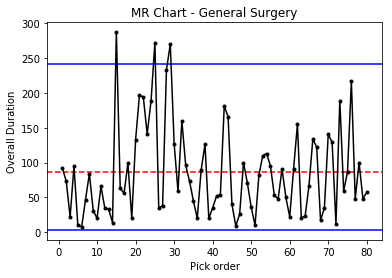

The upper bound is: 227.70912484289437
The lower bound is: 3.1837247340425536
The center line is: 81.03164556962025


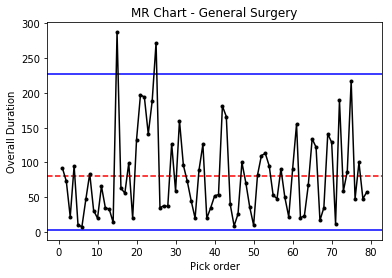

The upper bound is: 217.08222473404257
The lower bound is: 3.035144281914894
The center line is: 77.25


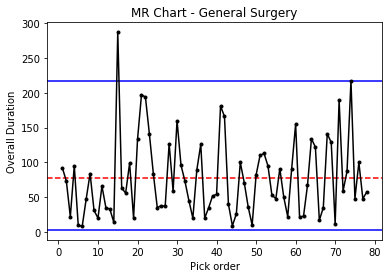

The upper bound is: 215.30308659159994
The lower bound is: 3.0102691869300915
The center line is: 76.61688311688312


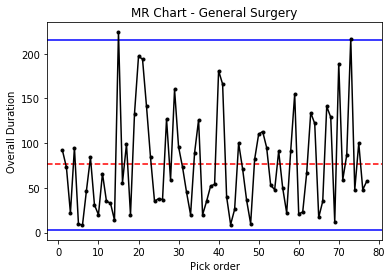

The upper bound is: 211.70231267497203
The lower bound is: 2.9599248145296757
The center line is: 75.33552631578948


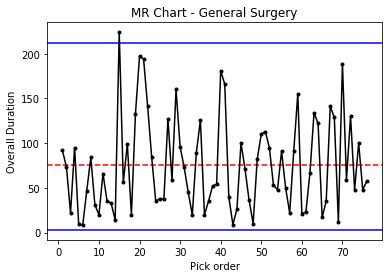

The upper bound is: 210.32855552009454
The lower bound is: 2.9407175709219855
The center line is: 74.84666666666666


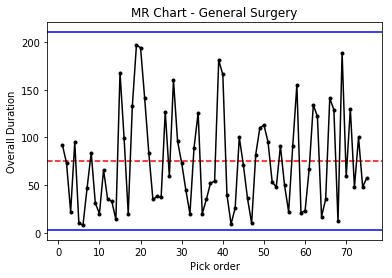

The MR chart went through 9 iterations, no more outliers!


In [57]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - General Surgery')

## I Chart

The upper bound is: 408.44050951847703
The lower bound is: -19.006298992161277
The center line is: 74.84666666666666


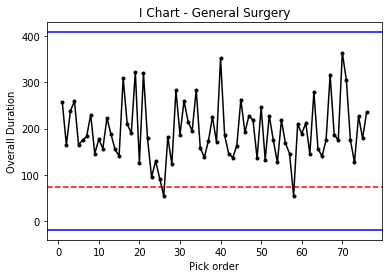

In [58]:
title = 'I Chart - General Surgery'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [59]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [60]:
count = 0
while(len(outlier_value) > 0):  
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I chart - General Surgery')

The I chart went through 0 iterations, no more outliers!


In [61]:
dataset_GS_final = dataset
dataset_GS_final.head()

OR case #  Overall Duration
0  GOR-2018-6929             257.0
1  GOR-2018-7414             165.0
2  GOR-2018-7082             238.0
3  GOR-2018-7420             260.0
4  GOR-2018-7453             165.0

# Surgical Specialty -- Dental

In [62]:
dental = df[(df['Surgical Specialty'] == 'Dental')
            |(df['Surgical Specialty'] == 'dental')
           ]
dental.head()

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-6116   2018/6/8        Christina        Cecilia   
GOR-2018-5735   2018/6/8        Christina        Cecilia   
GOR-2018-5696   2018/6/8        Christina        Cecilia   
GOR-2018-7809  2018/6/18        Christina       Plenamin   
GOR-2018-7378  2018/6/18        Christina       Plenamin   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6116                       20 Years   
GOR-2018-5735                       20 Years   
GOR-2018-5696                       20 Years   
GOR-2018-7809                       15 Years   
GOR-2018-7378                       15 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6116                                           Elective         
GOR-2018-5735                                           Elective         
GOR-2018-5696                                           Elective         
GOR-2018-7809                                           Elective         
GOR-2018-7378                                           Elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6116             Dental   10:53 AM                165.0   
GOR-2018-5735             Dental    1:12 PM                  NaN   
GOR-2018-5696             Dental    1:12 PM                  NaN   
GOR-2018-7809             Dental    3:25 PM                 85.0   
GOR-2018-7378             Dental    3:25 PM                 85.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6116             366.0           NaN  
GOR-2018-5735             457.0           NaN  
GOR-2018-5696             457.0           NaN  
GOR-2018-7809             200.0           NaN  
GOR-2018-7378             200.0           NaN

In [63]:
duplicate_dental = dental[dental.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_dental

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-5735   2018/6/8        Christina        Cecilia   
GOR-2018-5696   2018/6/8        Christina        Cecilia   
GOR-2018-7809  2018/6/18        Christina       Plenamin   
GOR-2018-7378  2018/6/18        Christina       Plenamin   
GOR-2018-7915  2018/6/18        Christina       Plenamin   
GOR-2018-6262  2018/6/18        Christina       Plenamin   
GOR-2018-7501  2018/6/25           Jialin       Plenamin   
GOR-2018-7383  2018/6/25           Jialin       Plenamin   
GOR-2018-3645  2018/6/25           Jialin       Plenamin   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-5735                       20 Years   
GOR-2018-5696                       20 Years   
GOR-2018-7809                       15 Years   
GOR-2018-7378                       15 Years   
GOR-2018-7915                       15 Years   
GOR-2018-6262                       15 Years   
GOR-2018-7501                       15 Years   
GOR-2018-7383                       15 Years   
GOR-2018-3645                       15 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-5735                                           Elective         
GOR-2018-5696                                           Elective         
GOR-2018-7809                                           Elective         
GOR-2018-7378                                           Elective         
GOR-2018-7915                                           Elective         
GOR-2018-6262                                           Elective         
GOR-2018-7501                                           elective         
GOR-2018-7383                                           elective         
GOR-2018-3645                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-5735             Dental    1:12 PM                  NaN   
GOR-2018-5696             Dental    1:12 PM                  NaN   
GOR-2018-7809             Dental    3:25 PM                 85.0   
GOR-2018-7378             Dental    3:25 PM                 85.0   
GOR-2018-7915             Dental    3:25 PM                 85.0   
GOR-2018-6262             Dental    3:25 PM                 85.0   
GOR-2018-7501             dental       3:03                 94.0   
GOR-2018-7383             dental       3:03                 94.0   
GOR-2018-3645             dental       3:03                 94.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-5735             457.0           NaN  
GOR-2018-5696             457.0           NaN  
GOR-2018-7809             200.0           NaN  
GOR-2018-7378             200.0           NaN  
GOR-2018-7915             200.0           NaN  
GOR-2018-6262             200.0           NaN  
GOR-2018-7501             211.0           NaN  
GOR-2018-7383             211.0           NaN  
GOR-2018-3645             211.0           NaN

In [64]:
#drop duplicates in original dataset
dental = dental.drop(duplicate_dental.index)
dental.head()

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-6116   2018/6/8        Christina        Cecilia   
GOR-2018-7151   2018/7/4        Christina       Plenamin   
GOR-2018-6699  2018/6/15             Emma         Elaine   
GOR-2018-      2018/6/13             Haya           Egna   
GOR-2018-7102  2018/6/20             Haya           Ella   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6116                       20 Years   
GOR-2018-7151                       15 Years   
GOR-2018-6699                       15 years   
GOR-2018-               >5 years (Part-time)   
GOR-2018-7102                     > 20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6116                                           Elective         
GOR-2018-7151                                           elective         
GOR-2018-6699                                           Elective         
GOR-2018-                                               elective         
GOR-2018-7102                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6116             Dental   10:53 AM                165.0   
GOR-2018-7151             dental    3:12 PM                  NaN   
GOR-2018-6699             Dental   11:34 AM                290.0   
GOR-2018-                 dental       4:22                  NaN   
GOR-2018-7102             dental      11:44                 98.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6116             366.0           NaN  
GOR-2018-7151             395.0           NaN  
GOR-2018-6699             878.0           NaN  
GOR-2018-                 380.0           NaN  
GOR-2018-7102             167.0           NaN

In [65]:
#number of duplicates in a given day and start time
dental_count = duplicate_dental.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
dental_count = dental_count.reset_index().drop(['Disposable Duration'], axis = 1)
dental_count = dental_count.rename(columns={'Overall Duration': 'Counts'})
dental_count

Date Start Time  Counts
0  2018/6/18    3:25 PM       4
1  2018/6/25       3:03       3
2   2018/6/8    1:12 PM       2

In [66]:
duplicate_dental = duplicate_dental.drop_duplicates(keep = 'first')
duplicate_dental

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-5735   2018/6/8        Christina        Cecilia   
GOR-2018-7809  2018/6/18        Christina       Plenamin   
GOR-2018-7501  2018/6/25           Jialin       Plenamin   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-5735                       20 Years   
GOR-2018-7809                       15 Years   
GOR-2018-7501                       15 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-5735                                           Elective         
GOR-2018-7809                                           Elective         
GOR-2018-7501                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-5735             Dental    1:12 PM                  NaN   
GOR-2018-7809             Dental    3:25 PM                 85.0   
GOR-2018-7501             dental       3:03                 94.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-5735             457.0           NaN  
GOR-2018-7809             200.0           NaN  
GOR-2018-7501             211.0           NaN

In [67]:
for i in range(len(dental_count['Counts'])):
    for j in range(len(duplicate_dental['Overall Duration'])):
        if dental_count['Date'][i] == duplicate_dental['Date'][j] and dental_count['Start Time'][i] == duplicate_dental['Start Time'][j]:
            duplicate_dental['Disposable Duration'][j] /= dental_count['Counts'][i]
            duplicate_dental['Overall Duration'][j] /= dental_count['Counts'][i]

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2862: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [68]:
duplicate_dental

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-5735   2018/6/8        Christina        Cecilia   
GOR-2018-7809  2018/6/18        Christina       Plenamin   
GOR-2018-7501  2018/6/25           Jialin       Plenamin   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-5735                       20 Years   
GOR-2018-7809                       15 Years   
GOR-2018-7501                       15 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-5735                                           Elective         
GOR-2018-7809                                           Elective         
GOR-2018-7501                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-5735             Dental    1:12 PM                  NaN   
GOR-2018-7809             Dental    3:25 PM            21.250000   
GOR-2018-7501             dental       3:03            31.333333   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-5735        228.500000           NaN  
GOR-2018-7809         50.000000           NaN  
GOR-2018-7501         70.333333           NaN

In [69]:
dental = pd.concat([dental, duplicate_dental],axis = 0)

In [70]:
dataset = dental['Overall Duration']
normality_check(dataset)

Data needs to be transformed


The upper bound is: 529.5213878841608
The lower bound is: 7.403525620567376
The center line is: 188.43333333333334


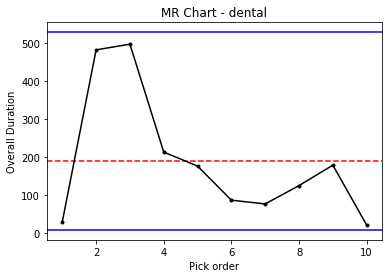

In [71]:
title = 'MR Chart - dental'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [72]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

In [73]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - General Surgery')

The MR chart went through 0 iterations, no more outliers!


## I Chart

The upper bound is: 546.4355254674404
The lower bound is: 118.98871695680208
The center line is: 188.43333333333334


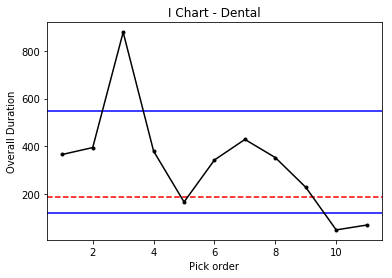

In [74]:
title = 'I Chart - Dental'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [75]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)


The upper bound is: 572.6734042553192
The lower bound is: 145.22659574468082
The center line is: 207.11111111111111


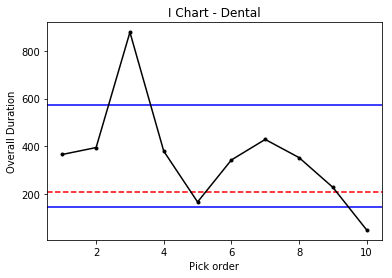

The upper bound is: 607.0011820330969
The lower bound is: 179.5543735224586
The center line is: 210.6875


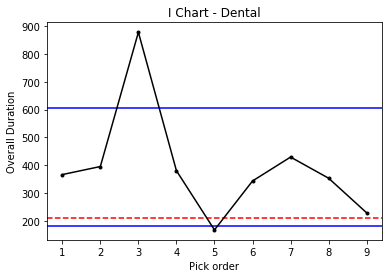

The upper bound is: 635.2859042553191
The lower bound is: 207.83909574468083
The center line is: 190.5


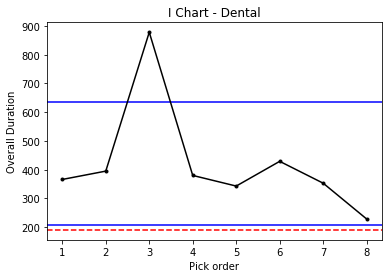

The upper bound is: 570.080547112462
The lower bound is: 142.63373860182367
The center line is: 61.25


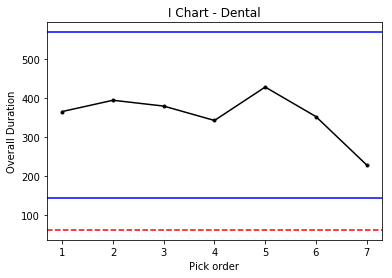

The I chart went through 4 iterations, no more outliers!


In [76]:
count = 0
while(len(outlier_value) > 0):  
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)        
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I chart - Dental')

In [77]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

OR case #  Overall Duration
0  GOR-2018-6116             366.0
1  GOR-2018-7151             395.0
2      GOR-2018-             380.0
3  GOR-2018-7110             343.0
4  GOR-2018-6302             429.0

# Surgical Specialty -- ENT

In [78]:
ent = df[(df['Surgical Specialty'] == 'ent')
         | (df['Surgical Specialty'] == 'ENT')]
ent.head()

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-6817   2018/6/8        Christina        Cecilia   
GOR-2018-6811   2018/6/8        Christina        Cecilia   
GOR-2018-6179   2018/6/8        Christina        Cecilia   
GOR-2018-7621  2018/6/18        Christina       Plenamin   
GOR-2018-8193   2018/7/4        Christina       Plenamin   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6817                       20 Years   
GOR-2018-6811                       20 Years   
GOR-2018-6179                       20 Years   
GOR-2018-7621                       15 Years   
GOR-2018-8193                       15 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6817                                           Elective         
GOR-2018-6811                                           Elective         
GOR-2018-6179                                           Elective         
GOR-2018-7621                                           Elective         
GOR-2018-8193                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6817                ENT   11:14 AM                134.0   
GOR-2018-6811                ENT   11:14 AM                134.0   
GOR-2018-6179                ENT   11:14 AM                134.0   
GOR-2018-7621                ENT    3:42 PM                207.0   
GOR-2018-8193                ENT    3:25 PM                  NaN   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6817             290.0           NaN  
GOR-2018-6811             290.0           NaN  
GOR-2018-6179             290.0           NaN  
GOR-2018-7621             335.0           NaN  
GOR-2018-8193             210.0           NaN

In [79]:
duplicate_ent = ent[ent.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_ent.head()

Date Name of Observer Name of Picker  \
OR case #                                                 
GOR-2018-6817  2018/6/8        Christina        Cecilia   
GOR-2018-6811  2018/6/8        Christina        Cecilia   
GOR-2018-6179  2018/6/8        Christina        Cecilia   
GOR-2018-8193  2018/7/4        Christina       Plenamin   
GOR-2018-8194  2018/7/4        Christina       Plenamin   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6817                       20 Years   
GOR-2018-6811                       20 Years   
GOR-2018-6179                       20 Years   
GOR-2018-8193                       15 Years   
GOR-2018-8194                       15 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6817                                           Elective         
GOR-2018-6811                                           Elective         
GOR-2018-6179                                           Elective         
GOR-2018-8193                                           elective         
GOR-2018-8194                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6817                ENT   11:14 AM                134.0   
GOR-2018-6811                ENT   11:14 AM                134.0   
GOR-2018-6179                ENT   11:14 AM                134.0   
GOR-2018-8193                ENT    3:25 PM                  NaN   
GOR-2018-8194                ENT    3:25 PM                  NaN   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6817             290.0           NaN  
GOR-2018-6811             290.0           NaN  
GOR-2018-6179             290.0           NaN  
GOR-2018-8193             210.0           NaN  
GOR-2018-8194             210.0           NaN

In [80]:
#drop duplicates in original dataset
ent = ent.drop(duplicate_ent.index)
ent.head()

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-7621  2018/6/18        Christina       Plenamin   
GOR-2018-7141   2018/6/5             Emma            Ann   
GOR-2018-7761  2018/6/12           Nathan        Cecilia   
GOR-2018-7542  2018/6/15             Emma            Ann   
GOR-2018-7884  2018/6/25           Jialin       Plenamin   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-7621                       15 Years   
GOR-2018-7141                     > 20 Years   
GOR-2018-7761                       20 Years   
GOR-2018-7542                     > 20 Years   
GOR-2018-7884                       15 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-7621                                           Elective         
GOR-2018-7141                                           Elective         
GOR-2018-7761                                          Emergency         
GOR-2018-7542                                           Elective         
GOR-2018-7884                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-7621                ENT    3:42 PM                207.0   
GOR-2018-7141                ENT    3:13 PM                 82.0   
GOR-2018-7761                ent   12:59 PM                161.0   
GOR-2018-7542                ENT    3:22 PM                 49.0   
GOR-2018-7884                ENT       3:11                 90.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-7621             335.0           NaN  
GOR-2018-7141              82.0           NaN  
GOR-2018-7761             269.0           NaN  
GOR-2018-7542              49.0           NaN  
GOR-2018-7884             135.0           NaN

In [81]:
#number of duplicates in a given day and start time
ent_count = duplicate_ent.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
ent_count = ent_count.reset_index().drop(['Disposable Duration'], axis = 1)
ent_count = ent_count.rename(columns={'Overall Duration': 'Counts'})

In [82]:
duplicate_ent = duplicate_ent.drop_duplicates(keep = 'first')
duplicate_ent.head()

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-6817   2018/6/8        Christina        Cecilia   
GOR-2018-8193   2018/7/4        Christina       Plenamin   
GOR 2018-7554  2018/6/16             Emma         Elaine   
GOR 2018-7550  2018/6/17             Emma         Elaine   
GOR-2018-7548  2018/6/15             Emma         Elaine   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6817                       20 Years   
GOR-2018-8193                       15 Years   
GOR 2018-7554                       16 years   
GOR 2018-7550                       17 years   
GOR-2018-7548                       15 years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6817                                           Elective         
GOR-2018-8193                                           elective         
GOR 2018-7554                                           Elective         
GOR 2018-7550                                           Elective         
GOR-2018-7548                                           Elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6817                ENT   11:14 AM                134.0   
GOR-2018-8193                ENT    3:25 PM                  NaN   
GOR 2018-7554                ENT    1:49 PM                149.0   
GOR 2018-7550                ENT    1:49 PM                149.0   
GOR-2018-7548                ENT    1:55 PM                239.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6817             290.0           NaN  
GOR-2018-8193             210.0           NaN  
GOR 2018-7554             338.0           NaN  
GOR 2018-7550             338.0           NaN  
GOR-2018-7548             390.0           NaN

In [83]:
for i in range(len(ent_count['Counts'])):
    for j in range(len(duplicate_ent['Overall Duration'])):
        if ent_count['Date'][i] == duplicate_ent['Date'][j] and ent_count['Start Time'][i] == duplicate_ent['Start Time'][j]:
            duplicate_ent['Disposable Duration'][j] /= ent_count['Counts'][i]
            duplicate_ent['Overall Duration'][j] /= ent_count['Counts'][i]

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/jiajialin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [84]:
duplicate_ent

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-6817   2018/6/8        Christina        Cecilia   
GOR-2018-8193   2018/7/4        Christina       Plenamin   
GOR 2018-7554  2018/6/16             Emma         Elaine   
GOR 2018-7550  2018/6/17             Emma         Elaine   
GOR-2018-7548  2018/6/15             Emma         Elaine   
GOR-2018-8215   2018/7/5             Emma       Plenamin   
GOR-2018-6552   2018/6/6             Haya             AM   
GOR-2018-7462  2018/6/13             Haya           Egna   
GOR-2018-7692  2018/6/20             Haya           Ella   
GOR-2018-7977  2018/6/27             Haya        Harrier   
GOR-2018-8158   2018/7/3             Haya          Iwona   
GOR-2018-7212   2018/6/7           Jialin              M   
GOR-2018-7561  2018/6/14           Jialin         Elaine   
GOR-2018-7874  2018/6/22           Jialin           Edna   
GOR-2018-8472   2018/7/6           Nathan           Ella   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6817                       20 Years   
GOR-2018-8193                       15 Years   
GOR 2018-7554                       16 years   
GOR 2018-7550                       17 years   
GOR-2018-7548                       15 years   
GOR-2018-8215                       15 Years   
GOR-2018-6552                     > 20 Years   
GOR-2018-7462           >5 years (Part-time)   
GOR-2018-7692                     > 20 Years   
GOR-2018-7977                       12 Years   
GOR-2018-8158                       15 Years   
GOR-2018-7212                    Experienced   
GOR-2018-7561                       15 years   
GOR-2018-7874                        9 years   
GOR-2018-8472                     > 20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6817                                           Elective         
GOR-2018-8193                                           elective         
GOR 2018-7554                                           Elective         
GOR 2018-7550                                           Elective         
GOR-2018-7548                                           Elective         
GOR-2018-8215                                           Elective         
GOR-2018-6552                                           Elective         
GOR-2018-7462                                           elective         
GOR-2018-7692                                           elective         
GOR-2018-7977                                           elective         
GOR-2018-8158                                           elective         
GOR-2018-7212                                           Elective         
GOR-2018-7561                                           Elective         
GOR-2018-7874                                           elective         
GOR-2018-8472                                           Elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6817                ENT   11:14 AM            44.666667   
GOR-2018-8193                ENT    3:25 PM                  NaN   
GOR 2018-7554                ENT    1:49 PM           149.000000   
GOR 2018-7550                ENT    1:49 PM           149.000000   
GOR-2018-7548                ENT    1:55 PM           119.500000   
GOR-2018-8215                ENT    4:03 PM            81.000000   
GOR-2018-6552                ENT    3:18 PM                  NaN   
GOR-2018-7462                ENT       4:16                  NaN   
GOR-2018-7692                ENT      11:04            29.000000   
GOR-2018-7977                ENT       3:25                  NaN   
GOR-2018-8158                ENT    4:28 PM                  NaN   
GOR-2018-7212                ENT    3:0

In [85]:
ent = pd.concat([ent, duplicate_ent],axis = 0)

In [86]:
dataset = ent['Overall Duration']
normality_check(dataset)

Data is normally distributed


In [87]:
title = 'MR Chart - ENT'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

The upper bound is: 271.84774627256604
The lower bound is: 3.8008507313829782
The center line is: 96.73863636363635


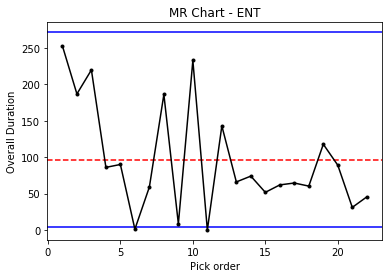

In [88]:
limits = control_limits(MR)
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [89]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

The upper bound is: 284.79287704745013
The lower bound is: 3.9818436233535963
The center line is: 101.34523809523807


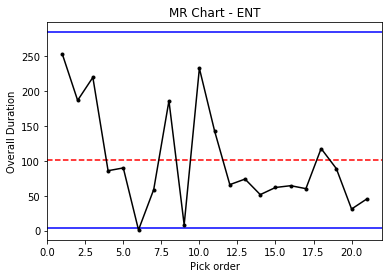

The upper bound is: 298.75150831117014
The lower bound is: 4.177006815159574
The center line is: 106.31249999999997


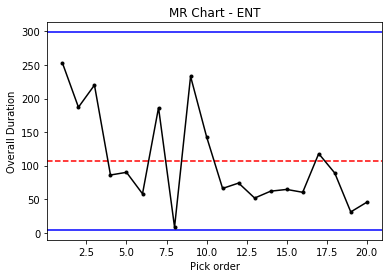

The MR chart went through 2 iterations, no more outliers!


In [90]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Dental')

## I Chart

The upper bound is: 361.0130867950017
The lower bound is: -66.43372171563664
The center line is: 106.31249999999997


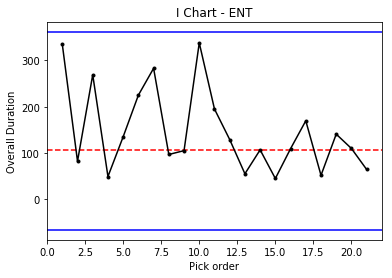

In [91]:
title = 'I Chart - ENT'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [92]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [94]:
count = 0
while(len(outlier_value) > 0): 
    count +=1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I Chart - ENT')

The I chart went through 0 iterations, no more outliers!


In [95]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

OR case #  Overall Duration
0  GOR-2018-7621             335.0
1  GOR-2018-7141              82.0
2  GOR-2018-7761             269.0
3  GOR-2018-7542              49.0
4  GOR-2018-7884             135.0

# Surgical Specialty -- Urology

In [96]:
uro = df[(df['Surgical Specialty'] == 'Urology')]
uro.head()

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-6819   2018/6/8        Christina        Cecilia   
GOR-2018-7092  2018/6/18        Christina       Plenamin   
GOR-2018-7094  2018/6/18        Christina       Plenamin   
4 pick sheets   2018/6/7           Jialin           Ella   
GOR-2018-6833  2018/6/26        Christina       Plenamin   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6819                       20 Years   
GOR-2018-7092                       15 Years   
GOR-2018-7094                       15 Years   
4 pick sheets                     > 20 Years   
GOR-2018-6833                       15 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6819                                           Elective         
GOR-2018-7092                                           Elective         
GOR-2018-7094                                           Elective         
4 pick sheets                              Emergency - Gold list         
GOR-2018-6833                                           Elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6819            Urology    1:03 PM                201.0   
GOR-2018-7092            Urology    3:49 PM                247.0   
GOR-2018-7094            Urology    3:49 PM                247.0   
4 pick sheets            Urology    7:05 AM                  NaN   
GOR-2018-6833            Urology    3:32 PM                502.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6819             503.0           NaN  
GOR-2018-7092             311.0           NaN  
GOR-2018-7094             311.0           NaN  
4 pick sheets             313.0           NaN  
GOR-2018-6833             502.0           NaN

In [97]:
duplicate_uro = uro[uro.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_uro

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-7092  2018/6/18        Christina       Plenamin   
GOR-2018-7094  2018/6/18        Christina       Plenamin   
GOR-2018-8461   2018/7/3           Jialin        Cecelia   
GOR-2018-8462   2018/7/3           Jialin        Cecelia   
GOR-2018-8460   2018/7/3           Jialin        Cecelia   
GOR-2018-7445  2018/6/12           Nathan           Edna   
GOR-2018-7456  2018/6/12           Nathan           Edna   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-7092                       15 Years   
GOR-2018-7094                       15 Years   
GOR-2018-8461                     > 20 Years   
GOR-2018-8462                     > 20 Years   
GOR-2018-8460                     > 20 Years   
GOR-2018-7445                        9 years   
GOR-2018-7456                        9 years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-7092                                           Elective         
GOR-2018-7094                                           Elective         
GOR-2018-8461                                          Emergency         
GOR-2018-8462                                          Emergency         
GOR-2018-8460                                          Emergency         
GOR-2018-7445                                           elective         
GOR-2018-7456                                           elective         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-7092            Urology    3:49 PM                247.0   
GOR-2018-7094            Urology    3:49 PM                247.0   
GOR-2018-8461            Urology    7:08 AM                186.0   
GOR-2018-8462            Urology    7:08 AM                186.0   
GOR-2018-8460            Urology    7:08 AM                186.0   
GOR-2018-7445            Urology      16:30                192.0   
GOR-2018-7456            Urology      16:30                192.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-7092             311.0           NaN  
GOR-2018-7094             311.0           NaN  
GOR-2018-8461             259.0           NaN  
GOR-2018-8462             259.0           NaN  
GOR-2018-8460             259.0           NaN  
GOR-2018-7445             192.0           NaN  
GOR-2018-7456             192.0           NaN

In [98]:
#drop duplicates in original dataset
uro = uro.drop(duplicate_uro.index)
uro.head()

Date Name of Observer Name of Picker  \
OR case #                                                  
GOR-2018-6819   2018/6/8        Christina        Cecilia   
4 pick sheets   2018/6/7           Jialin           Ella   
GOR-2018-6833  2018/6/26        Christina       Plenamin   
GOR-2018-7952  2018/6/26        Christina       Plenamin   
GOR-2018-7717  2018/6/12           Nathan        Cecilia   

              Picker's Year(s) of Experience  \
OR case #                                      
GOR-2018-6819                       20 Years   
4 pick sheets                     > 20 Years   
GOR-2018-6833                       15 Years   
GOR-2018-7952                       15 Years   
GOR-2018-7717                       20 Years   

              Elective/ Emergency/ Red Dot (Urgent) eg. cardiac arrest  \
OR case #                                                                
GOR-2018-6819                                           Elective         
4 pick sheets                              Emergency - Gold list         
GOR-2018-6833                                           Elective         
GOR-2018-7952                                           Elective         
GOR-2018-7717                                          Emergency         

              Surgical Specialty Start Time  Disposable Duration  \
OR case #                                                          
GOR-2018-6819            Urology    1:03 PM                201.0   
4 pick sheets            Urology    7:05 AM                  NaN   
GOR-2018-6833            Urology    3:32 PM                502.0   
GOR-2018-7952            Urology    3:42 PM                473.0   
GOR-2018-7717            Urology    7:08 AM                 72.0   

               Overall Duration  Distractions  
OR case #                                      
GOR-2018-6819             503.0           NaN  
4 pick sheets             313.0           NaN  
GOR-2018-6833             502.0           NaN  
GOR-2018-7952             473.0           NaN  
GOR-2018-7717              72.0           NaN

In [99]:
#number of duplicates in a given day and start time
uro_count = duplicate_uro.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
uro_count = uro_count.reset_index().drop(['Disposable Duration'], axis = 1)
uro_count = uro_count.rename(columns={'Overall Duration': 'Counts'})
uro_count

Date Start Time  Counts
0  2018/6/12      16:30       2
1  2018/6/18    3:49 PM       2
2   2018/7/3    7:08 AM       3

In [ ]:
duplicate_uro = duplicate_uro.drop_duplicates(keep = 'first')
duplicate_uro

In [ ]:
for i in range(len(uro_count['Counts'])):
    for j in range(len(duplicate_uro['Overall Duration'])):
        if uro_count['Date'][i] == duplicate_uro['Date'][j] and uro_count['Start Time'][i] == duplicate_uro['Start Time'][j]:
            duplicate_uro['Disposable Duration'][j] /= uro_count['Counts'][i]
            duplicate_uro['Overall Duration'][j] /= uro_count['Counts'][i]

In [ ]:
duplicate_uro

In [ ]:
uro = pd.concat([uro, duplicate_uro],axis = 0)

In [ ]:
title = 'MR Chart - Urology'
dataset = uro['Overall Duration']
normality_check(dataset)

In [ ]:
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [ ]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Urology')

## I Chart

In [ ]:
title = 'I Chart - Urology'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [ ]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [ ]:
while(len(outlier_value) > 0):  
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, simga)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)

print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I Chart - Urology')

In [ ]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

# Surgical Specialty -- Gynaecology

In [ ]:
gyn = df[(df['Surgical Specialty'] == 'Gynecology')]
gyn.head()

In [ ]:
duplicate_gyn = gyn[gyn.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_gyn

In [ ]:
#drop duplicates in original dataset
gyn = gyn.drop(duplicate_gyn.index)
gyn.head()

In [ ]:
#number of duplicates in a given day and start time
gyn_count = duplicate_gyn.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
gyn_count = gyn_count.reset_index().drop(['Disposable Duration'], axis = 1)
gyn_count = gyn_count.rename(columns={'Overall Duration': 'Counts'})
gyn_count

In [ ]:
duplicate_gyn = duplicate_gyn.drop_duplicates(keep = 'first')
duplicate_gyn

In [ ]:
for i in range(len(gyn_count['Counts'])):
    for j in range(len(duplicate_gyn['Overall Duration'])):
        if gyn_count['Date'][i] == duplicate_gyn['Date'][j] and gyn_count['Start Time'][i] == duplicate_gyn['Start Time'][j]:
            duplicate_gyn['Disposable Duration'][j] /= gyn_count['Counts'][i]
            duplicate_gyn['Overall Duration'][j] /= gyn_count['Counts'][i]

In [ ]:
duplicate_gyn

In [ ]:
gyn = pd.concat([gyn, duplicate_gyn],axis = 0)

In [ ]:
dataset = gyn['Overall Duration']
normality_check(dataset)

In [ ]:
title = 'MR Chart - Gynaecology'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [ ]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

In [ ]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Gynaecology')

## I Chart

In [ ]:
title = 'I Chart - Gynaecology'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [ ]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [ ]:
count = 0
while(len(outlier_value) > 0):  
    count +=1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I Chart - Gynaecology')

In [ ]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

# Surgical Specialty -- Plastics

In [ ]:
plastic = df[(df['Surgical Specialty'] == 'Plastics')]
plastic.head()

In [ ]:
duplicate_plastic = plastic[plastic.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_plastic

In [ ]:
#drop duplicates in original dataset
plastic = plastic.drop(duplicate_plastic.index)
plastic.head()

In [ ]:
#number of duplicates in a given day and start time
plastic_count = duplicate_plastic.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
plastic_count = plastic_count.reset_index().drop(['Disposable Duration'], axis = 1)
plastic_count = plastic_count.rename(columns={'Overall Duration': 'Counts'})
plastic_count

In [ ]:
duplicate_plastic = duplicate_plastic.drop_duplicates(keep = 'first')
duplicate_plastic

In [ ]:
for i in range(len(plastic_count['Counts'])):
    for j in range(len(duplicate_plastic['Overall Duration'])):
        if plastic_count['Date'][i] == duplicate_plastic['Date'][j] and plastic_count['Start Time'][i] == duplicate_plastic['Start Time'][j]:
            duplicate_plastic['Disposable Duration'][j] /= plastic_count['Counts'][i]
            duplicate_plastic['Overall Duration'][j] /= plastic_count['Counts'][i]

duplicate_plastic

In [ ]:
plastic = pd.concat([plastic, duplicate_plastic],axis = 0)
plastic.head()

In [ ]:
dataset = plastic['Overall Duration']
normality_check(dataset)

In [ ]:
title = 'MR Chart - Plastics'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [ ]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

In [ ]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Plastics')

## I Chart

In [ ]:
title = 'I Chart - Plastics'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [ ]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [ ]:
count = 0
while(len(outlier_value) > 0): 
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)

print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I Chart - Plastics')

In [ ]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

# Surgical Specialty -- Ophthalmology

In [ ]:
ophtha = df[(df['Surgical Specialty'] == 'Ophthalmology')]
ophtha.shape[0]

# Surgical Specialty -- Laparoscopic Cholecystectomy

In [ ]:
LC = df[(df['Surgical Specialty'] == 'Laparoscopic Cholecystectomy')]
LC.head()

In [ ]:
LC.shape[0]

# Surgical Specialty -- Cysto

In [ ]:
cysto = df[(df['Surgical Specialty'] == 'Cysto')
           | (df['Surgical Specialty'] == 'cysto')]
cysto.head()

In [ ]:
cysto.shape[0]

In [ ]:
duplicate_cysto = cysto[cysto.duplicated(['Start Time', 'Disposable Duration', 'Overall Duration'], keep = False)]
duplicate_cysto

#drop duplicates in original dataset
cysto = cysto.drop(duplicate_cysto.index)
cysto.head()

#number of duplicates in a given day and start time
cysto_count = duplicate_cysto.groupby(['Date','Start Time'])['Disposable Duration','Overall Duration'].count()
cysto_count = cysto_count.reset_index().drop(['Disposable Duration'], axis = 1)
cysto_count = cysto_count.rename(columns={'Overall Duration': 'Counts'})
cysto_count

duplicate_cysto = duplicate_cysto.drop_duplicates(keep = 'first')
duplicate_cysto

for i in range(len(cysto_count['Counts'])):
    for j in range(len(duplicate_cysto['Overall Duration'])):
        if cysto_count['Date'][i] == duplicate_cysto['Date'][j] and cysto_count['Start Time'][i] == duplicate_cysto['Start Time'][j]:
            duplicate_cysto['Disposable Duration'][j] /= cysto_count['Counts'][i]
            duplicate_cysto['Overall Duration'][j] /= cysto_count['Counts'][i]

duplicate_cysto

cysto = pd.concat([plastic, duplicate_plastic],axis = 0)
cysto.head()

In [ ]:
dataset = cysto['Overall Duration']
normality_check(dataset)

In [ ]:
title = 'MR Chart - Cysto'
dataset = dataset.reset_index()
#x-axis
MRi = MR_i(dataset)[0]
MR = MR_i(dataset)[1]
x_axis = np.arange(1,len(MRi)+1,1)

limits = control_limits(MR)
MRchart(limits[0],limits[1],limits[2])
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]

In [ ]:
outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = remove_outlier(outlier_value, outlier_idx)

In [ ]:
count = 0
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)
    #MR = MR_i(dataset)[1]
    x_axis = np.arange(1,len(MRi)+1,1)

    limits = control_limits(MR)
    MRchart(limits[0],limits[1],limits[2])
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]

    outlier_value, outlier_idx = check_outlier(MRi, UCL, LCL)
    if (len(outlier_idx) != 0):
        dataset = remove_outlier(outlier_value, outlier_idx)
print('The MR chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('MR Chart - Cysto')

## I Chart

In [ ]:
title = 'I Chart - Cysto'
#x-axis
x_axis = np.arange(1,len(dataset)+1,1)

limits = I_control_limits(MR, sigma)
UCL = limits[0]
LCL = limits[1]
Centre = limits[2]
Ichart(LCL, UCL, Centre)

In [ ]:
outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
if len(outlier_idx) != 0:
    dataset = I_remove_outlier(outlier_value, outlier_idx)

In [ ]:
count = 0 
while(len(outlier_value) > 0):
    count += 1
    #x-axis
    dataset = dataset.reset_index(drop = True)
    MRi, MR = MR_i(dataset)

    x_axis = np.arange(1,len(dataset)+1,1)

    limits = I_control_limits(MR, sigma)
    UCL = limits[0]
    LCL = limits[1]
    Centre = limits[2]
    Ichart(LCL, UCL, Centre)

    outlier_value, outlier_idx = I_check_outlier(MRi, UCL, LCL)
    if len(outlier_idx) != 0:
        dataset = I_remove_outlier(outlier_value, outlier_idx)
    
print('The I chart went through ' + str(count) + ' iterations, no more outliers!')
plt.savefig('I Chart - Cysto')

In [ ]:
dataset_ortho_final = dataset
dataset_ortho_final.head()

# Surgical Specialty -- Lapidectomy

In [ ]:
lapid = df[(df['Surgical Specialty'] == 'Lapidectomy')]
lapid.head()

In [ ]:
lapid.shape[0]